## Setup

In [25]:
# GCP environment variables
PROJECT_ID='mg-ce-demos'
REGION = 'us-central1'
DATANAME = 'stock_forecast_demo'
NOTEBOOK = 'model'

BQ_SOURCE = 'mg-ce-demos.stock_forecast_demo.stock_forecast_demo_raw'

In [6]:
# packages for data prep
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

## BigQuery - Data Review

In [7]:
# no auth required in this case, due to running in managed notebook
bigquery = bigquery.Client()

In [11]:
## create dataset if it doesn't already exist
## in this case, dataset already exists
#query = f"""
#CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{DATANAME}`
#OPTIONS(
#    location = 'US',
#    labels = [('notebook','{NOTEBOOK}')]
#)
#"""
#job = bigquery.query(query = query)
#job.result()

In [12]:
query = f"""
SELECT * 
FROM `{BQ_SOURCE}`
LIMIT 5
"""
preview = bigquery.query(query = query).to_dataframe()
preview

Date   Open  High    Low   Close    Volume Name
0  2017-07-31    NaN   NaN    NaN  242.46   5777271   BA
1  2009-03-02  30.96  31.0  29.32   29.51  13957450   BA
2  2009-07-09  39.75  40.0  39.02   39.30   5432882   BA
3  2008-12-01  41.64  42.0  39.74   39.88   7902844   BA
4  2008-12-16  39.21  42.0  38.20   41.90  11043685   BA

In [52]:
query = f"""
WITH STOCKS AS(
    SELECT
       Name,
       Date,
       Close
    FROM `{BQ_SOURCE}`
)
SELECT Name, Close, min(Date) as FromDate, max(Date) as ToDate
FROM STOCKS
GROUP BY Name, Close
ORDER BY Name, Close
"""
overview = bigquery.query(query = query).to_dataframe()
overview

Name   Close    FromDate      ToDate
0      AABA    8.95  2008-11-20  2008-11-20
1      AABA    9.14  2008-11-19  2008-11-19
2      AABA    9.39  2008-11-21  2008-11-21
3      AABA   10.07  2008-11-25  2008-11-25
4      AABA   10.21  2008-11-24  2008-11-24
...     ...     ...         ...         ...
68802   XOM  103.83  2014-06-20  2014-06-20
68803   XOM  104.25  2014-07-23  2014-07-23
68804   XOM  104.28  2014-07-24  2014-07-24
68805   XOM  104.37  2014-07-28  2014-07-28
68806   XOM  104.38  2014-06-23  2014-06-23

[68807 rows x 4 columns]

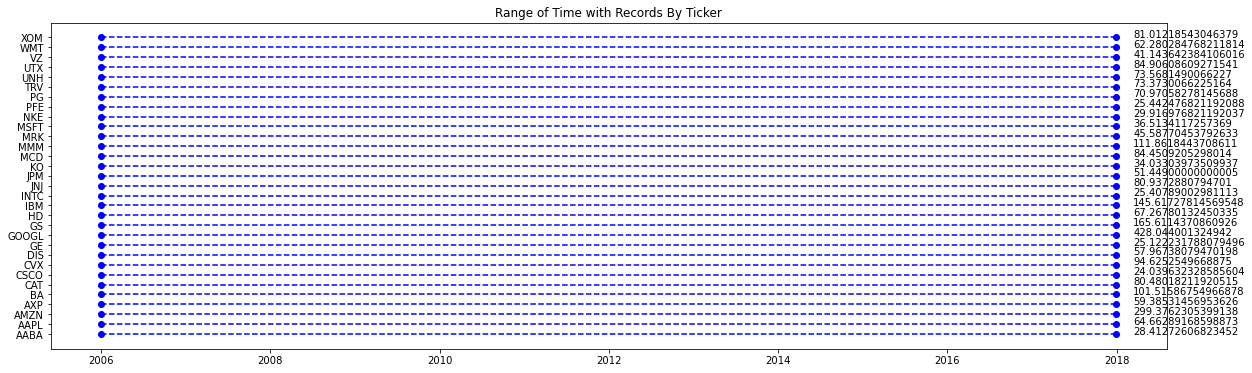

In [16]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['Name'][i], overview['Name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview['avg_close'][i]))
    plt.title('Range of Time with Records By Ticker')
plt.show()

In [17]:
# Propose train, test, validation splits
forecast_horizon = 14

query = f"""
WITH
    ALLDATES AS(
        SELECT Date
        FROM `{BQ_SOURCE}`
    ),
    KEYS AS(
        SELECT 
            MIN(Date) as start_date,
            DATE_SUB(MAX(Date), INTERVAL 2*{forecast_horizon}-1 DAY) as val_start,
            DATE_SUB(MAX(Date), INTERVAL {forecast_horizon}-1 DAY) as test_start,
            MAX(Date) as end_date
        FROM ALLDATES  
    )
SELECT *, DATE_DIFF(end_date, test_start, DAY)+1 as forecast_horizon
FROM KEYS
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date  forecast_horizon
0  2006-01-03  2017-12-02  2017-12-16  2017-12-29                14

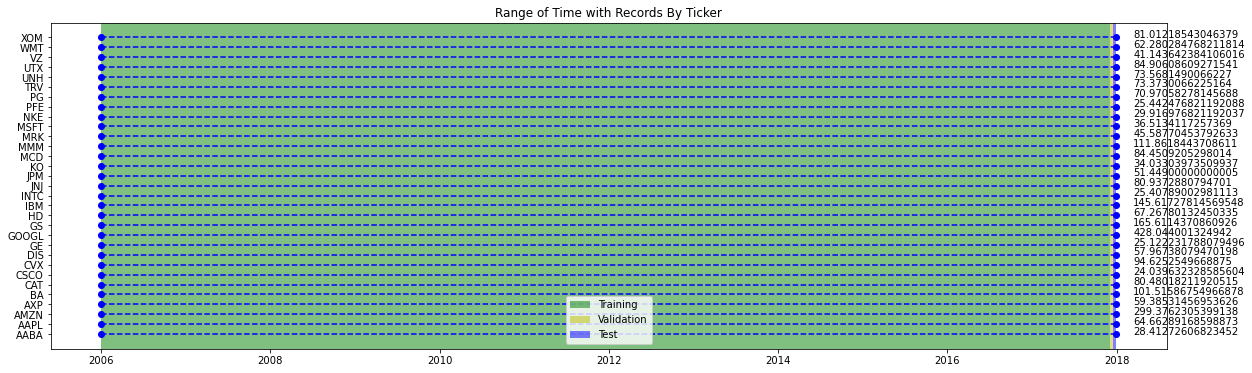

In [18]:
plt.figure(figsize=(20,6))
for i in range(len(overview)):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview['Name'][i], overview['Name'][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview['avg_close'][i]))
    plt.title('Range of Time with Records By Ticker')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

In [53]:
# Create table to be used for forecast
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped` AS
WITH
    DAYS AS(
        SELECT
           Name as name,
           Date as date,
           Close as close
        FROM `{BQ_SOURCE}`
    )
SELECT *,
   CASE
       WHEN date < DATE({keyDates['val_start'][0].strftime('%Y, %m, %d')}) THEN "TRAIN"
       WHEN date < DATE({keyDates['test_start'][0].strftime('%Y, %m, %d')}) THEN "VALIDATE"
       ELSE "TEST"
   END AS splits
FROM DAYS
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.662

In [55]:
# Review new table
query = f"""
SELECT 
    name,
    COUNTIF(splits='TRAIN') as TRAIN,
    COUNTIF(splits='VALIDATE') as VALIDATE,
    COUNTIF(splits='TEST') as TEST,
    AVG(Close) as avg_close
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
GROUP BY name
ORDER BY name
"""
splitCounts = bigquery.query(query = query).to_dataframe()
splitCounts

name  TRAIN  VALIDATE  TEST   avg_close
0    AABA   3000        10     9   28.412726
1    AAPL   3000        10     9   64.662892
2    AMZN   3000        10     9  299.376231
3     AXP   3001        10     9   59.385315
4      BA   3001        10     9  101.515868
5     CAT   3001        10     9   80.480182
6    CSCO   3000        10     9   24.039632
7     CVX   3001        10     9   94.625255
8     DIS   3001        10     9   57.967381
9      GE   3001        10     9   25.122232
10  GOOGL   3000        10     9  428.044001
11     GS   3001        10     9  165.611437
12     HD   3001        10     9   67.267801
13    IBM   3001        10     9  145.617278
14   INTC   3000        10     9   25.407890
15    JNJ   3001        10     9   80.937288
16    JPM   3001        10     9   51.449000
17     KO   3001        10     9   34.033040
18    MCD   3001        10     9   84.450921
19    MMM   3001        10     9  111.861844
20    MRK   3000        10     9   45.587705
21   MSFT   3000        10     9   36.513412
22    NKE   3001        10     9   29.916977
23    PFE   3001        10     9   25.442477
24     PG   3001        10     9   70.970583
25    TRV   3001        10     9   73.373007
26    UNH   3001        10     9   73.568149
27    UTX   3001        10     9   84.906086
28     VZ   3001        10     9   41.143642
29    WMT   3001        10     9   62.280285
30    XOM   3001        10     9   81.012185

In [56]:
# Review and visualize time series data
query = f"""
SELECT 
    name, date, splits, close
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()
rawSeries.head()

name        date splits  close
0  AABA  2006-01-03  TRAIN  40.91
1  AABA  2006-01-04  TRAIN  40.97
2  AABA  2006-01-05  TRAIN  41.53
3  AABA  2006-01-06  TRAIN  43.21
4  AABA  2006-01-09  TRAIN  43.42

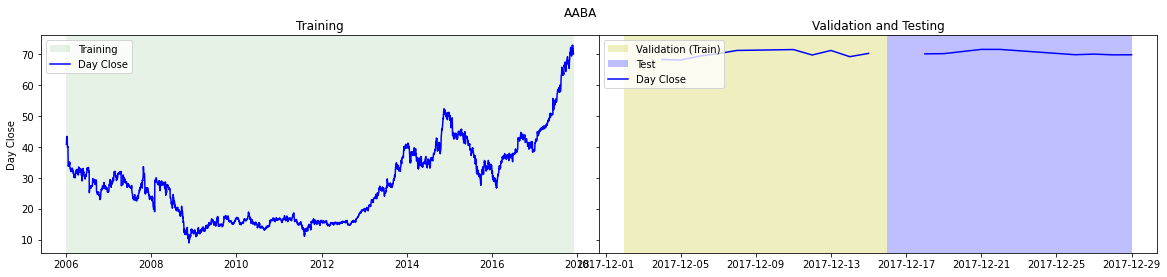

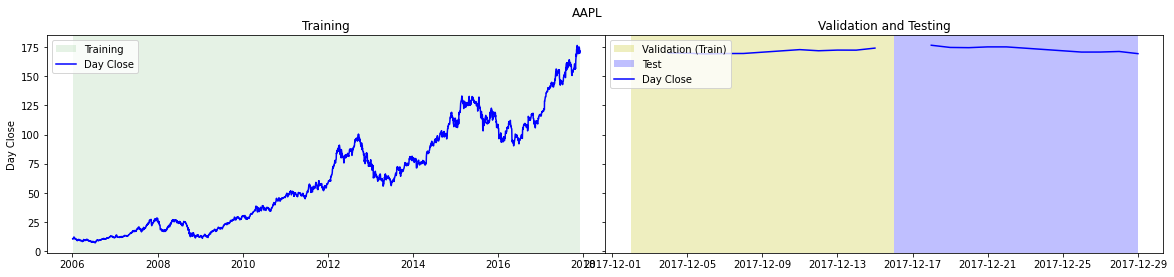

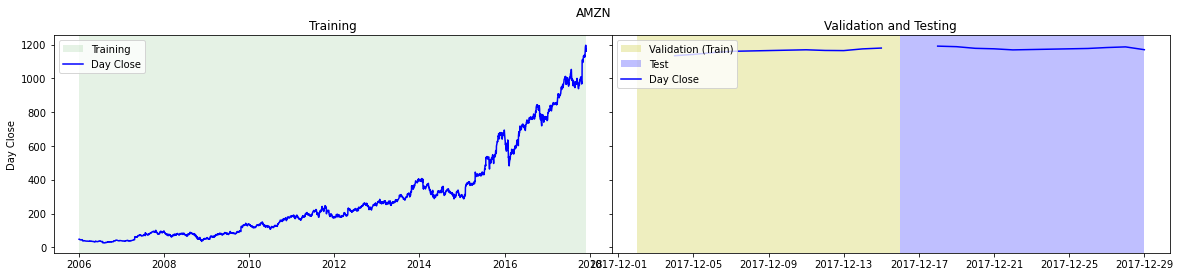

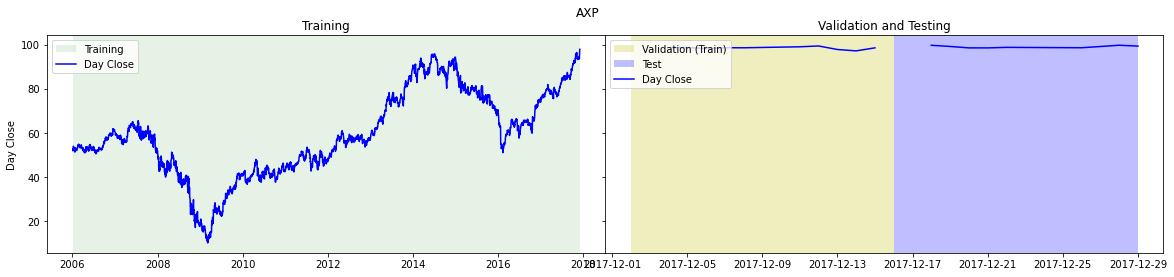

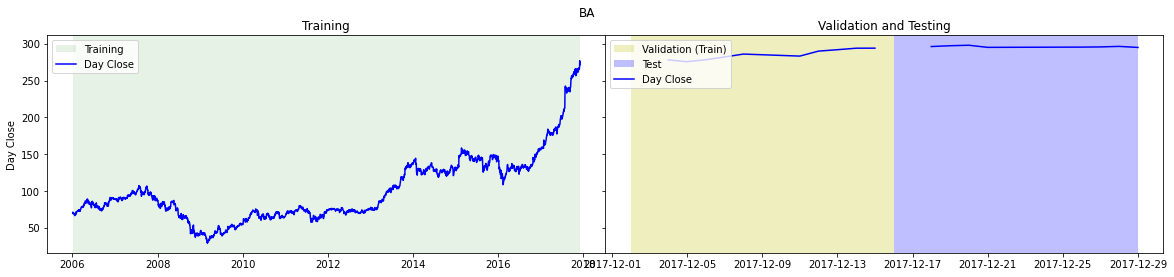

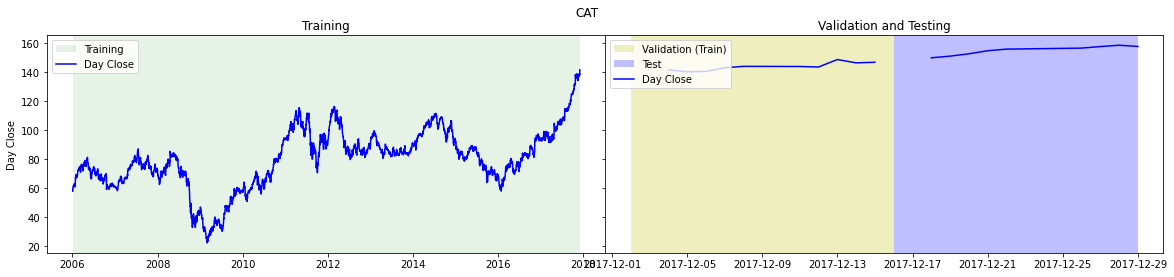

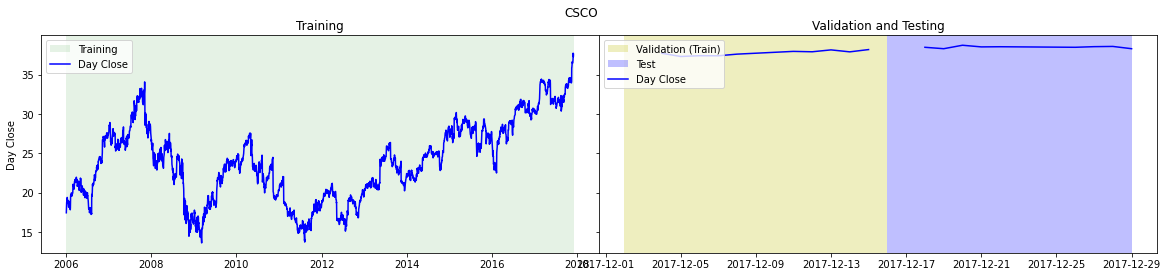

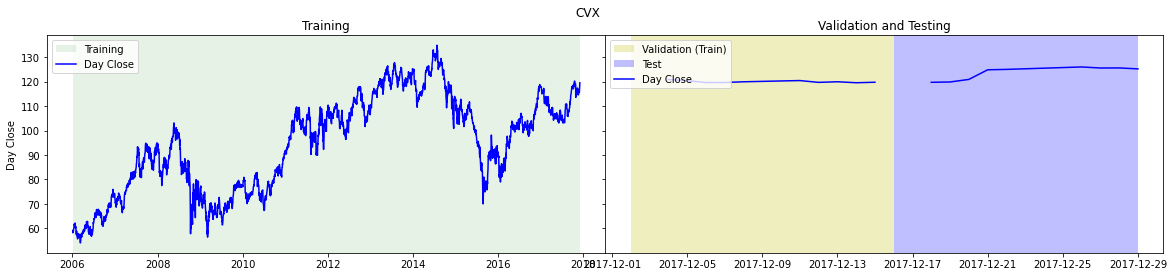

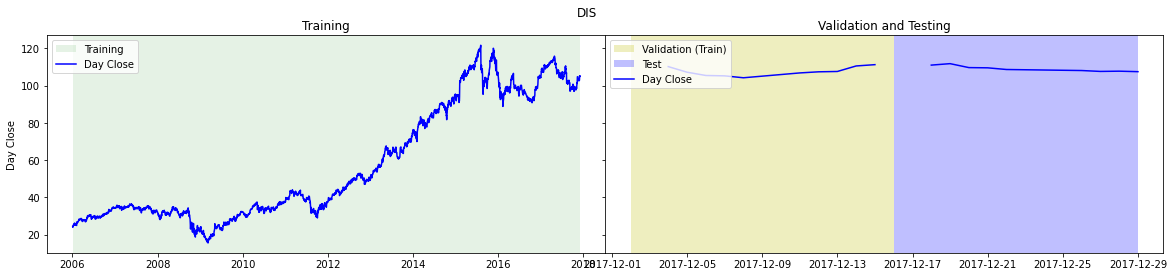

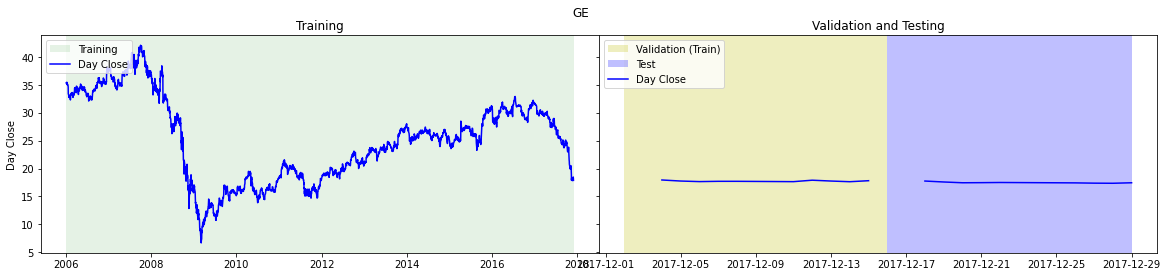

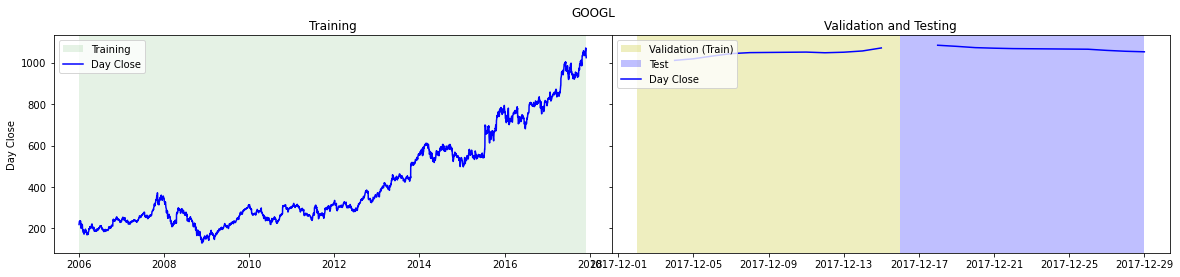

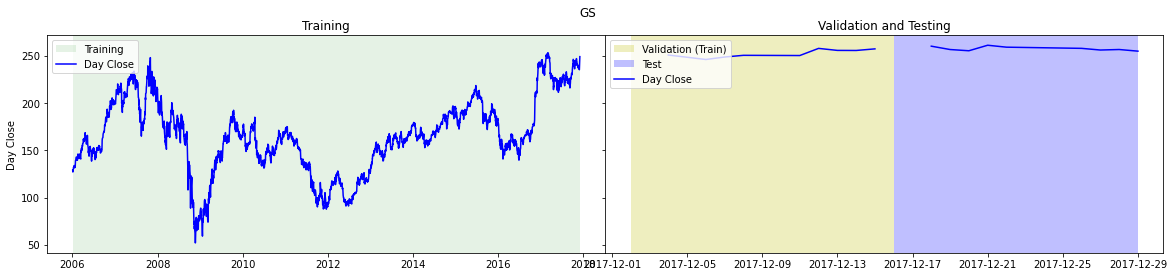

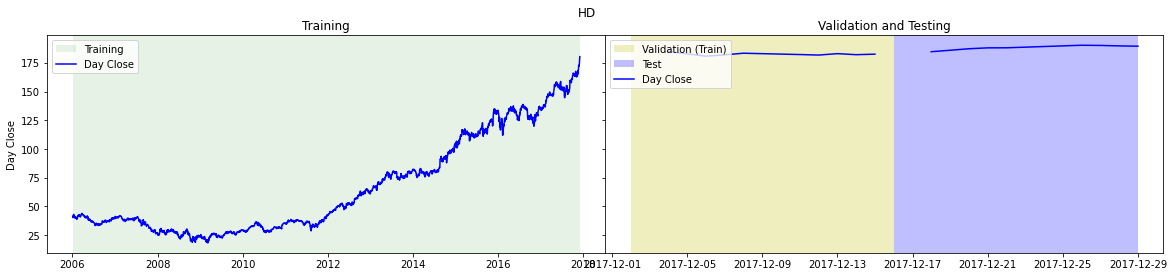

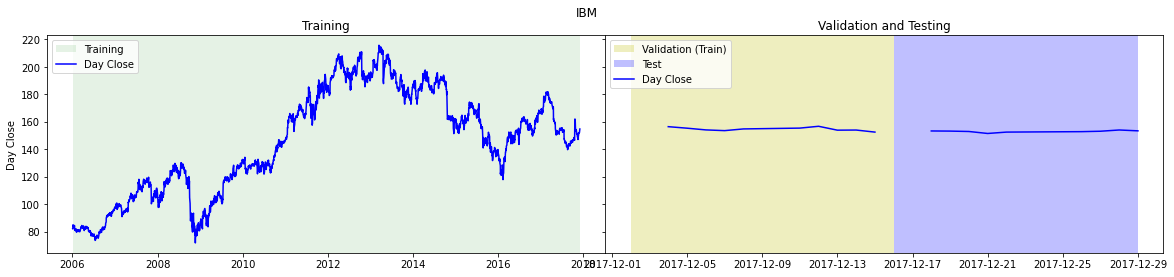

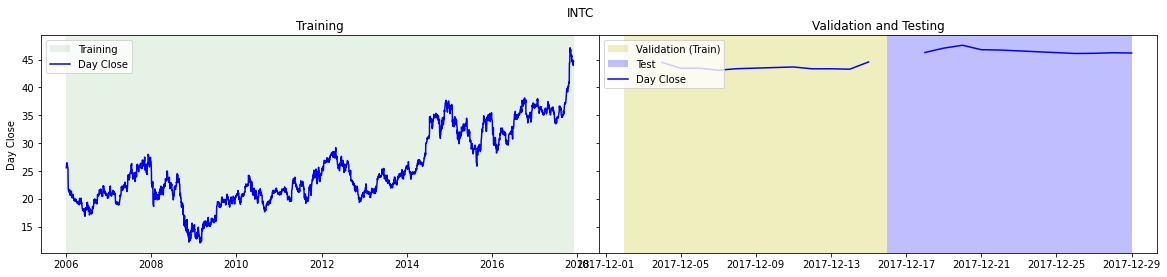

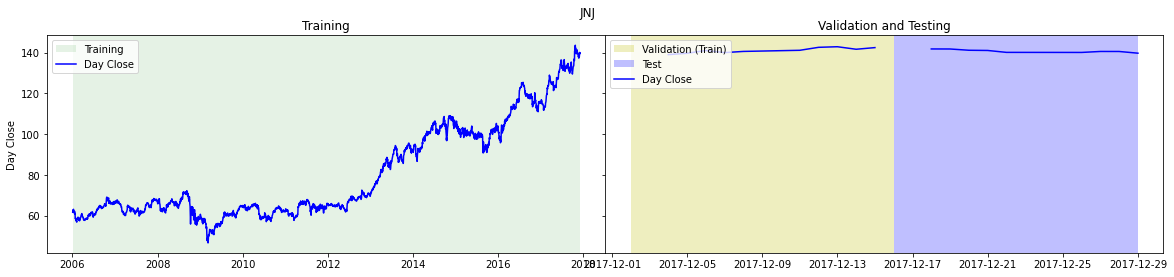

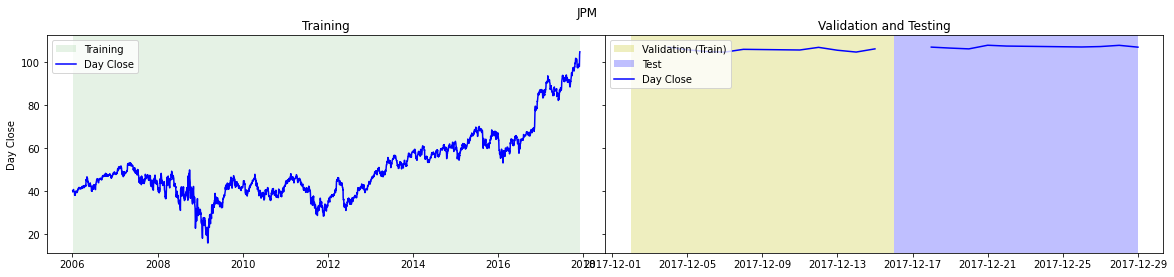

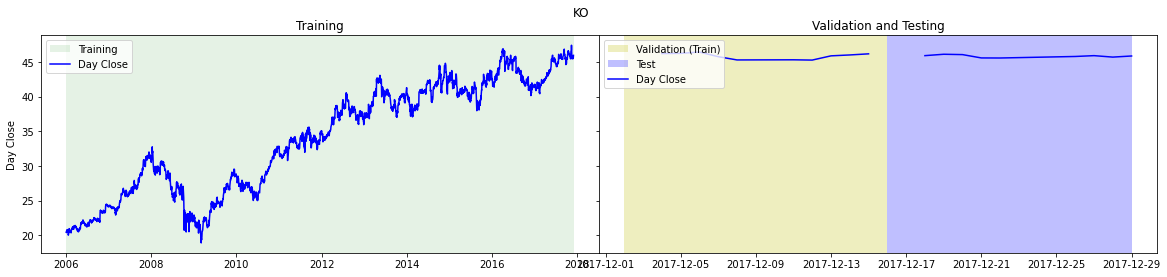

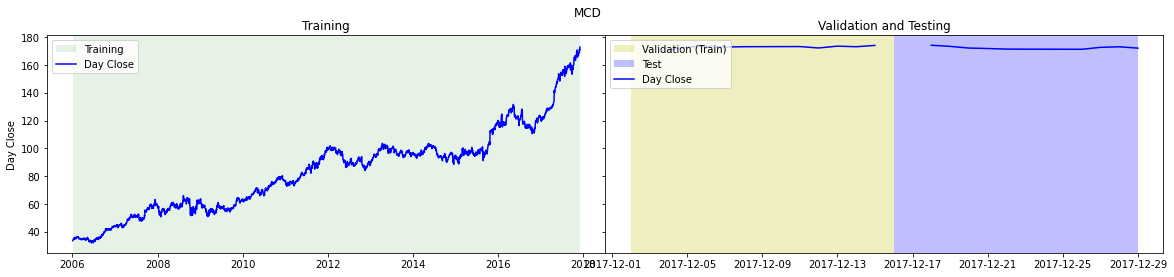

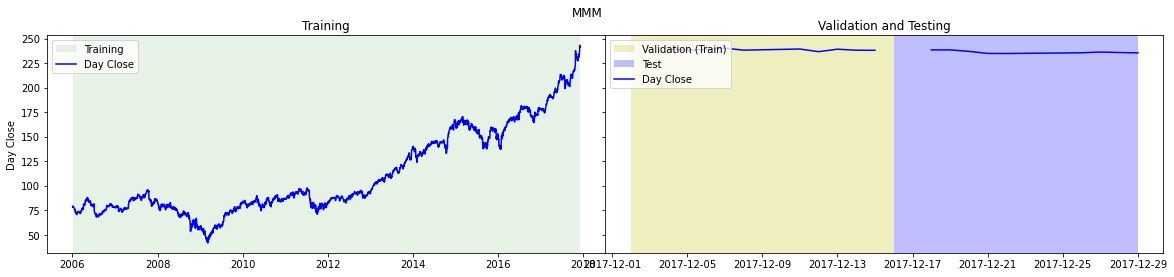

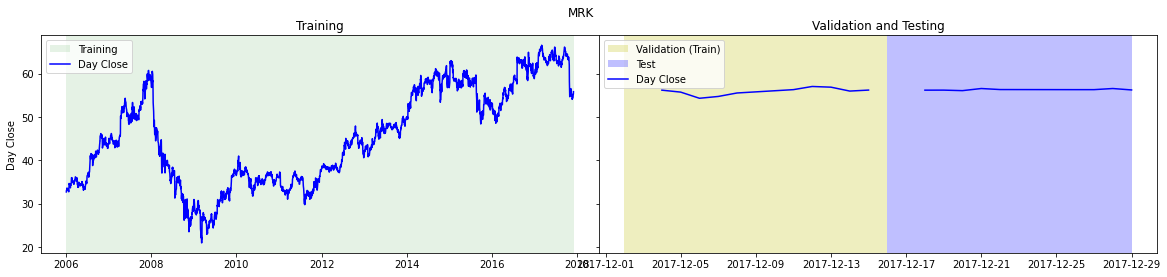

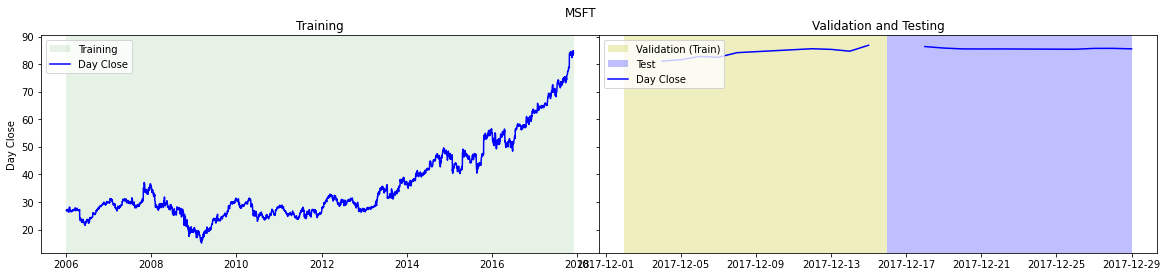

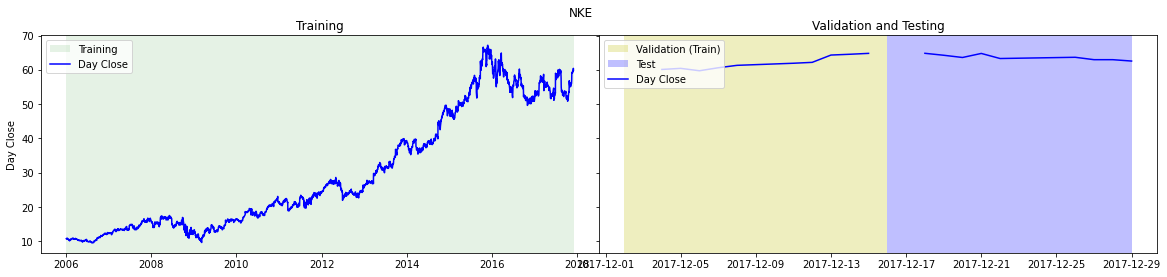

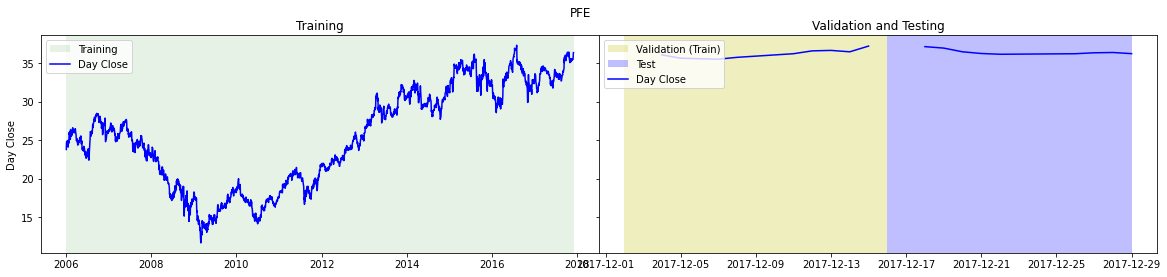

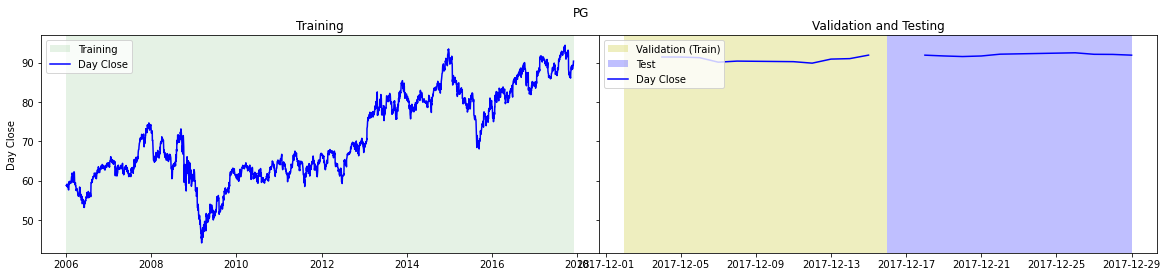

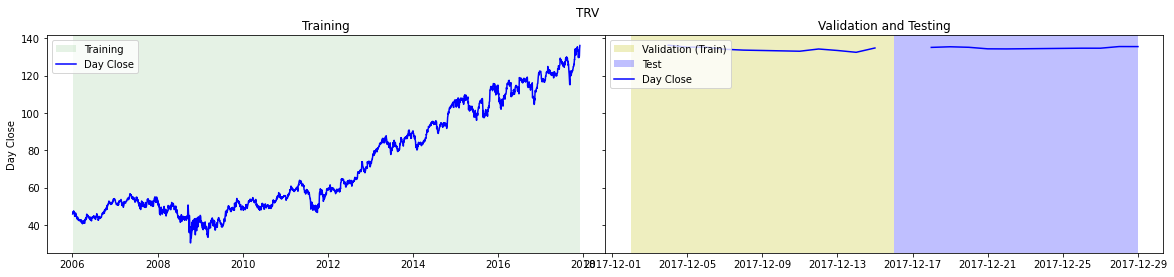

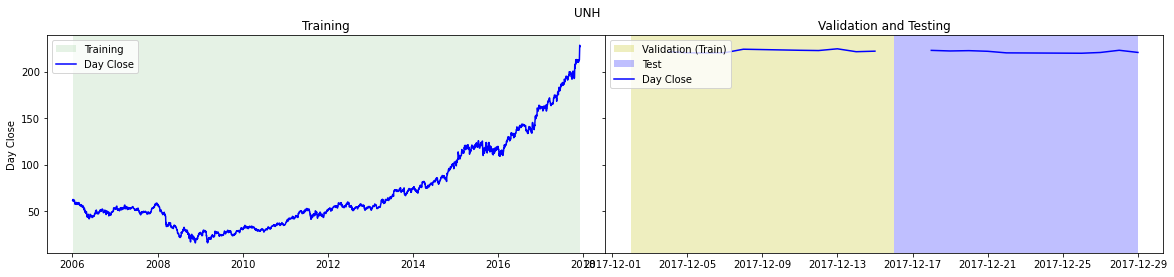

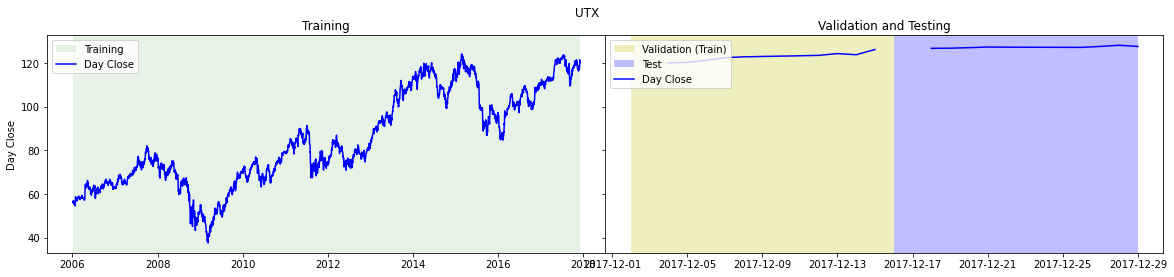

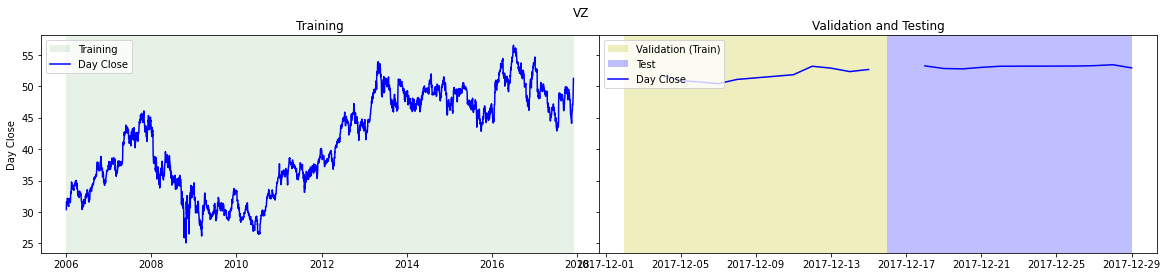

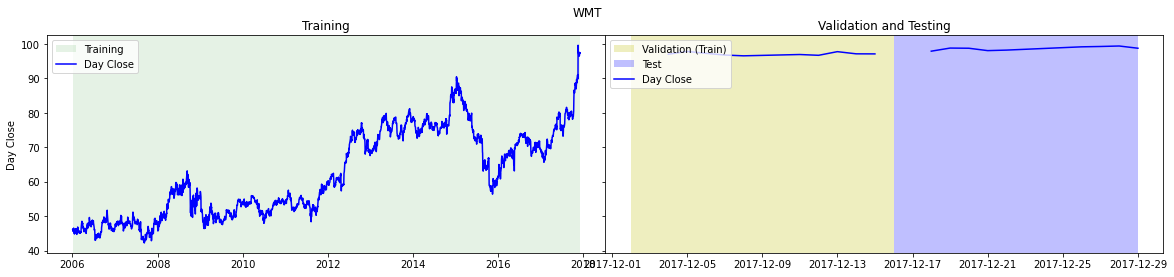

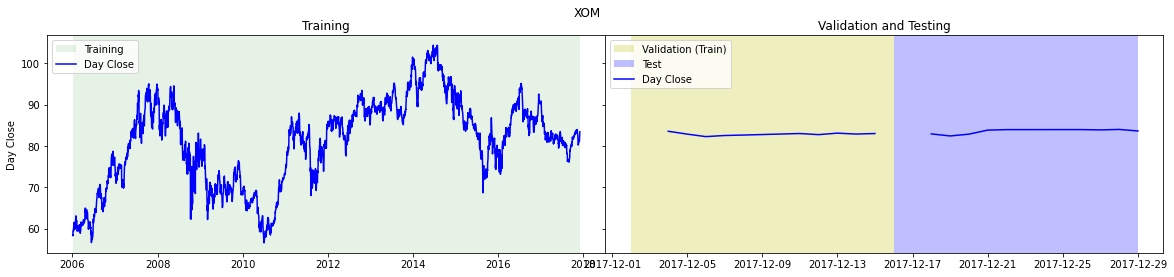

In [58]:
stocks = rawSeries['name'].unique().tolist()
for s, st in enumerate(stocks):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['close'], color = 'b', label = 'Day Close')
    axes[1].plot(valdf['date'], valdf['close'], color = 'b', label = 'Day Close')
    axes[1].plot(testdf['date'], testdf['close'], color = 'b')
    
    # labels
    axes[0].set_ylabel('Day Close')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

## BQML - ARIMA+

Multiple time series are forcasted at the same time, each individual Stock using the time_series_id_col = input. ARIMA forecasting is univariate and does not use the validation data so we include it with the training data

### Model Training and Eval

In [59]:
query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`
OPTIONS
  (model_type = 'ARIMA_PLUS',
   time_series_timestamp_col = 'date',
   time_series_data_col = 'close',
   time_series_id_col = 'name',
   auto_arima_max_order = 5,
   holiday_region = 'US',
   horizon = {2*keyDates['forecast_horizon'][0]}
  ) AS
SELECT name, date, close
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
WHERE splits in ('TRAIN','VALIDATE')
"""
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

219.552

In [60]:
# Review arima coefficients
query = f"""
SELECT *
FROM ML.ARIMA_COEFFICIENTS(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`)
ORDER BY name
"""
coefficients = bigquery.query(query = query).to_dataframe()
coefficients.head()

name                                    ar_coefficients  \
0  AABA  [-0.6839442673217782, 0.17556596643787736, 0.1...   
1  AAPL                                                 []   
2  AMZN                                                 []   
3   AXP          [1.2039074799265639, -0.7403982118471836]   
4    BA                                                 []   

                                     ma_coefficients  intercept_or_drift  
0                                [0.785753998349883]            0.000000  
1  [0.05800489316988012, 0.3484291015755601, 0.36...            0.034327  
2  [-0.9014404676383123, 0.02961640615888589, -0....            0.000000  
3          [-1.2643606298822336, 0.9136976317305815]            0.000000  
4  [-0.8698656045726583, -0.11680445434776217, 0....            0.000000

In [61]:
# Review input features
query = f"""
SELECT *
FROM ML.FEATURE_INFO(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`)
"""
featureInfo = bigquery.query(query = query).to_dataframe()
featureInfo.head()

input   min      max       mean  median      stddev  category_count  \
0  Close  6.66  1195.83  85.345225   60.56  107.236772             NaN   
1   Date   NaN      NaN        NaN     NaN         NaN          3011.0   
2   Name   NaN      NaN        NaN     NaN         NaN            31.0   

   null_count  
0           0  
1           0  
2           0

In [62]:
# Review training information
query = f"""
SELECT *
FROM ML.TRAINING_INFO(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`)
"""
trainingInfo = bigquery.query(query = query).to_dataframe()
trainingInfo.head()

training_run  iteration  duration_ms
0             0          0       212149

### Forecast

In [63]:
# Review forecast metrics
query = f"""
SELECT *
FROM ML.EVALUATE(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`,
(
    SELECT name, date, close
    FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST'
),
STRUCT(TRUE AS perform_aggregation))
"""
metrics = bigquery.query(query = query).to_dataframe()
metrics

name  mean_absolute_error  mean_squared_error  root_mean_squared_error  \
0    AABA             0.713704            0.730266                 0.854556   
1    AAPL             2.650250            8.379924                 2.894810   
2    AMZN            18.690371          470.737291                21.696481   
3     AXP             0.653338            0.958371                 0.978964   
4      BA             5.812081           40.133155                 6.335073   
5     CAT            11.997104          148.027819                12.166668   
6    CSCO             1.375521            1.975104                 1.405384   
7     CVX             3.664115           16.658516                 4.081484   
8     DIS             1.487365            2.858843                 1.690811   
9      GE             1.886193            3.626383                 1.904307   
10  GOOGL            12.409122          235.210929                15.336588   
11     GS             1.640605            4.805461                 2.192136   
12     HD             8.735833           78.127816                 8.838994   
13    IBM             2.284129            6.673340                 2.583281   
14   INTC             3.214052           10.717954                 3.273829   
15    JNJ             0.762740            0.809156                 0.899531   
16    JPM             1.459348            2.657667                 1.630235   
17     KO             0.679937            0.577691                 0.760060   
18    MCD             1.771540            3.728334                 1.930889   
19    MMM             2.722244            8.597835                 2.932207   
20    MRK             0.600235            0.499497                 0.706751   
21   MSFT             1.022676            1.395809                 1.181444   
22    NKE             0.870153            1.145556                 1.070307   
23    PFE             0.648185            0.465406                 0.682206   
24     PG             0.558673            0.345529                 0.587817   
25    TRV             0.750790            0.766899                 0.875728   
26    UNH             4.824727           26.275423                 5.125956   
27    UTX             0.978542            1.048087                 1.023761   
28     VZ             1.989106            4.073423                 2.018272   
29    WMT             4.298700           18.812277                 4.337312   
30    XOM             0.278714            0.143590                 0.378933   

    mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                         0.010182                                  0.010114  
1                         0.015364                                  0.015331  
2                         0.015797                                  0.015967  
3                         0.006578                                  0.006618  
4                         0.019617                                  0.019848  
5                         0.077260                                  0.080441  
6                         0.035711                                  0.036389  
7                         0.029363                                  0.029905  
8                         0.013633                                  0.013608  
9                         0.107955                                  0.102322  
10                        0.011588                                  0.011630  
11                        0.006342                                  0.006366  
12                        0.046346                                  0.047469  
13                        0.014917                                  0.015060  
14                        0.068937                                  0.071487  
15                        0.005421                                  0.005416  
16                        0.013607                                  0.013724  
17                        0.014848                    

Evaluate the models:
    
A per time series, specified with time_series_id_col at creation, model metrics table: ARIMA terms:

    p = how many autoregressive terms
    d = how many nonseasonal differences needed for stationarity
    q = number of lagged forecast errors (moving average part)

In [64]:
query = f"""
SELECT *
FROM ML.ARIMA_EVALUATE(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`)
ORDER BY name
"""
metrics = bigquery.query(query = query).to_dataframe()
metrics

name  non_seasonal_p  non_seasonal_d  non_seasonal_q  has_drift  \
0    AABA               4               1               1      False   
1    AAPL               0               1               5       True   
2    AMZN               0               2               4      False   
3     AXP               2               1               2      False   
4      BA               0               2               5      False   
5     CAT               3               1               2       True   
6    CSCO               0               1               5      False   
7     CVX               0               1               5      False   
8     DIS               2               1               3      False   
9      GE               3               1               2      False   
10  GOOGL               0               1               5      False   
11     GS               3               1               2      False   
12     HD               0               2               5      False   
13    IBM               3               1               2      False   
14   INTC               3               1               2      False   
15    JNJ               0               2               5      False   
16    JPM               1               1               4      False   
17     KO               2               1               3      False   
18    MCD               0               2               5      False   
19    MMM               3               1               2       True   
20    MRK               2               1               2      False   
21   MSFT               0               2               5      False   
22    NKE               4               1               1       True   
23    PFE               0               1               5      False   
24     PG               0               1               5      False   
25    TRV               3               1               2       True   
26    UNH               3               1               2       True   
27    UTX               2               1               3       True   
28     VZ               3               1               2       True   
29    WMT               3               1               2       True   
30    XOM               2               1               3       True   

    log_likelihood           AIC   variance  seasonal_periods  \
0     -2013.210396   4038.420793   0.147301  [WEEKLY, YEARLY]   
1     -3887.823658   7789.647316   0.347643  [WEEKLY, YEARLY]   
2    -11152.763773  22315.527546   9.712781  [WEEKLY, YEARLY]   
3     -3462.504149   6935.008298   0.286157  [WEEKLY, YEARLY]   
4     -5780.972859  11573.945719   0.827842  [WEEKLY, YEARLY]   
5     -5214.967495  10443.934989   0.638851  [WEEKLY, YEARLY]   
6        66.561013   -121.122027   0.056772  [WEEKLY, YEARLY]   
7     -4578.864367   9169.728733   0.476722  [WEEKLY, YEARLY]   
8     -3182.176442   6376.352883   0.251686  [WEEKLY, YEARLY]   
9       970.728399  -1929.456797   0.037510  [WEEKLY, YEARLY]   
10   -12013.186432  24038.372865  14.402820  [WEEKLY, YEARLY]   
11    -9123.265825  18258.531649   3.830242          [WEEKLY]   
12    -3633.278500   7278.556999   0.309148  [WEEKLY, YEARLY]   
13    -6323.261222  12658.522445   1.061416  [WEEKLY, YEARLY]   
14      360.548304   -709.096608   0.049611  [WEEKLY, YEARLY]   
15    -2163.956027   4339.912054   0.157364  [WEEKLY, YEARLY]   
16    -3264.466318   6540.932635   0.260793  [WEEKLY, YEARLY]   
17     1400.582109  -2789.164218   0.030783  [WEEKLY, YEARLY]   
18    -3141.055098   6294.110197   0.246794  [WEEKLY, YEARLY]   
19    -5005.754226  10025.508452   0.580467  [WEEKLY, YEARLY]   
20    -1649.930255   3309.860510   0.124678  [WEEKLY, YEARLY]   
21    -1316.318854   2644.637708   0.106910  [WEEKLY, YEARLY]   
22     -148.182970    310.365940   0.062662  [WEEKLY, YEARLY]   
23     1951.579321  -3891.158642   0.023864  [WEEKLY, YEARLY]   
24    -1985.516031   3983.032062   0.145362  [WEEKLY, YEARLY]   
25    -305

Calculates the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level.

The default horizon is 3 so this parameter may need to be set to the size used at training.

In [65]:
query = f"""
SELECT *
FROM ML.FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`, STRUCT(7 AS horizon, 0.95 AS confidence_level))
ORDER BY name
"""
forecast = bigquery.query(query = query).to_dataframe()
forecast

name        forecast_timestamp  forecast_value  standard_error  \
0    AABA 2017-12-16 00:00:00+00:00       70.820046        0.383798   
1    AABA 2017-12-17 00:00:00+00:00       71.020152        0.571071   
2    AABA 2017-12-18 00:00:00+00:00       70.763642        0.735514   
3    AABA 2017-12-19 00:00:00+00:00       70.863963        0.884631   
4    AABA 2017-12-20 00:00:00+00:00       70.910210        1.034750   
..    ...                       ...             ...             ...   
212   XOM 2017-12-18 00:00:00+00:00       82.916116        0.938536   
213   XOM 2017-12-19 00:00:00+00:00       83.302412        1.166881   
214   XOM 2017-12-20 00:00:00+00:00       83.474091        1.422082   
215   XOM 2017-12-21 00:00:00+00:00       83.602611        1.651045   
216   XOM 2017-12-22 00:00:00+00:00       83.809224        1.830468   

     confidence_level  prediction_interval_lower_bound  \
0                0.95                        70.069161   
1                0.95                        69.902876   
2                0.95                        69.324639   
3                0.95                        69.133220   
4                0.95                        68.885765   
..                ...                              ...   
212              0.95                        81.079909   
213              0.95                        81.019459   
214              0.95                        80.691848   
215              0.95                        80.372411   
216              0.95                        80.227990   

     prediction_interval_upper_bound  confidence_interval_lower_bound  \
0                          71.570930                        70.069161   
1                          72.137428                        69.902876   
2                          72.202644                        69.324639   
3                          72.594705                        69.133220   
4                          72.934654                        68.885765   
..                               ...                              ...   
212                        84.752322                        81.079909   
213                        85.585365                        81.019459   
214                        86.256334                        80.691848   
215                        86.832811                        80.372411   
216                        87.390459                        80.227990   

     confidence_interval_upper_bound  
0                          71.570930  
1                          72.137428  
2                          72.202644  
3                          72.594705  
4                          72.934654  
..                               ...  
212                        84.752322  
213                        85.585365  
214                        86.256334  
215                        86.832811  
216                        87.390459  

[217 rows x 9 columns]

BigQuery ML has an enhanced forecasting function that also include explaination information. One of the default parameters for the model_type = 'ARIMA_PLUS' is decompost_timer_series = True which enable this functionality.

In addition to forecast an the accompanying prediction intervals, this also includes the actual value and infromation for trend, seasonality, holiday effects, spikes and dips, and step changes.

In [66]:
query = f"""
SELECT *, EXTRACT(DATE FROM time_series_timestamp) AS date
FROM ML.EXPLAIN_FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`, STRUCT({2*keyDates['forecast_horizon'][0]} AS horizon, 0.95 AS confidence_level))
ORDER BY name, time_series_timestamp
"""
explain = bigquery.query(query = query).to_dataframe()

In [67]:
explain.head()


name     time_series_timestamp time_series_type  time_series_data  \
0  AABA 2006-01-03 00:00:00+00:00          history             40.91   
1  AABA 2006-01-04 00:00:00+00:00          history             40.97   
2  AABA 2006-01-05 00:00:00+00:00          history             41.53   
3  AABA 2006-01-06 00:00:00+00:00          history             43.21   
4  AABA 2006-01-07 00:00:00+00:00          history             43.28   

   time_series_adjusted_data  standard_error  confidence_level  \
0                  31.319228        0.383798               NaN   
1                  30.953249        0.383798               NaN   
2                  31.793874        0.383798               NaN   
3                  32.614346        0.383798               NaN   
4                  33.931368        0.383798               NaN   

   prediction_interval_lower_bound  prediction_interval_upper_bound  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4                              NaN                              NaN   

       trend  seasonal_period_yearly  seasonal_period_quarterly  \
0   0.000000                0.808524                        NaN   
1  30.384227                1.131644                        NaN   
2  30.854203                1.440119                        NaN   
3  31.070900                1.719236                        NaN   
4  32.208264                1.660310                        NaN   

   seasonal_period_monthly  seasonal_period_weekly  seasonal_period_daily  \
0                      NaN                0.126480                    NaN   
1                      NaN               -0.562622                    NaN   
2                      NaN               -0.500448                    NaN   
3                      NaN               -0.175790                    NaN   
4                      NaN                0.062795                    NaN   

   holiday_effect  spikes_and_dips  step_changes        date  
0             0.0              0.0      9.590772  2006-01-03  
1             0.0              0.0      9.590772  2006-01-04  
2             0.0              0.0      9.590772  2006-01-05  
3             0.0              0.0      9.590772  2006-01-06  
4             0.0              0.0      9.590772  2006-01-07

### Visualize time series and forecast

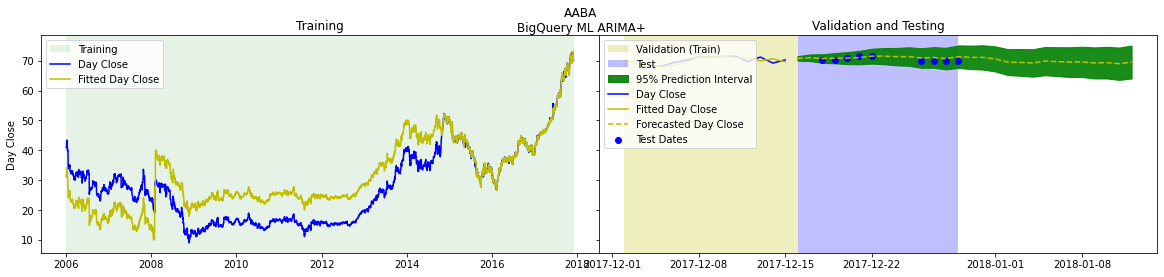

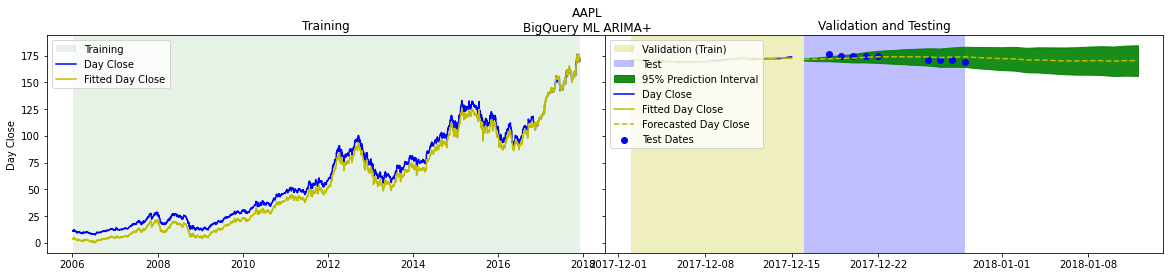

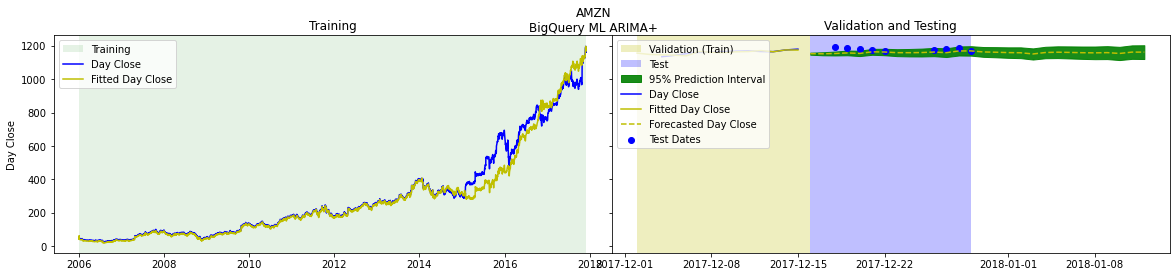

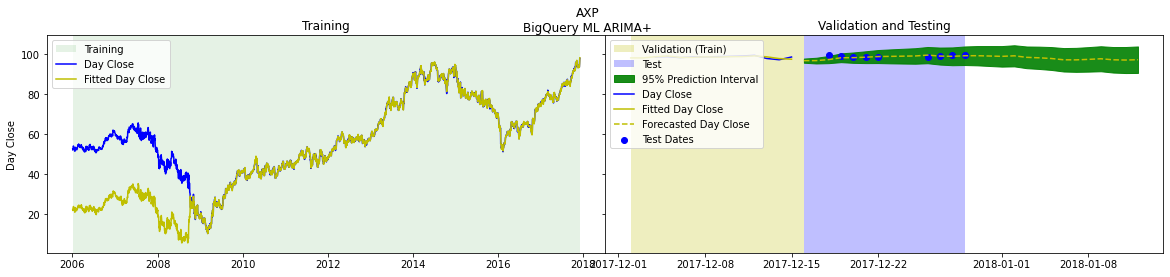

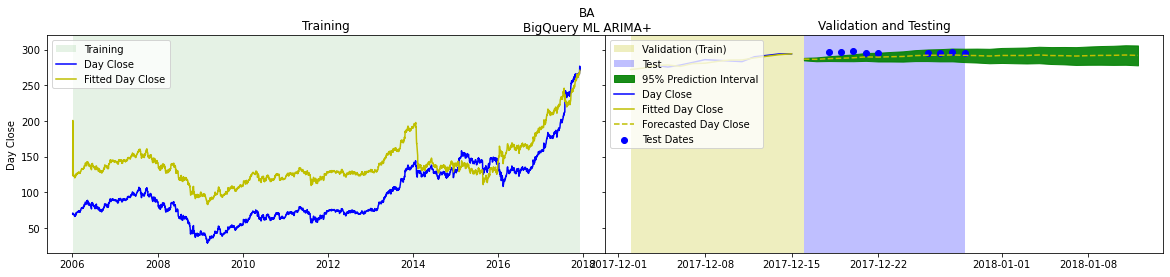

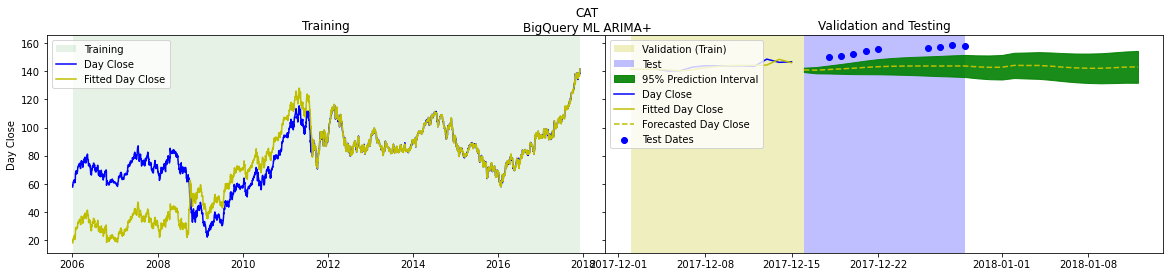

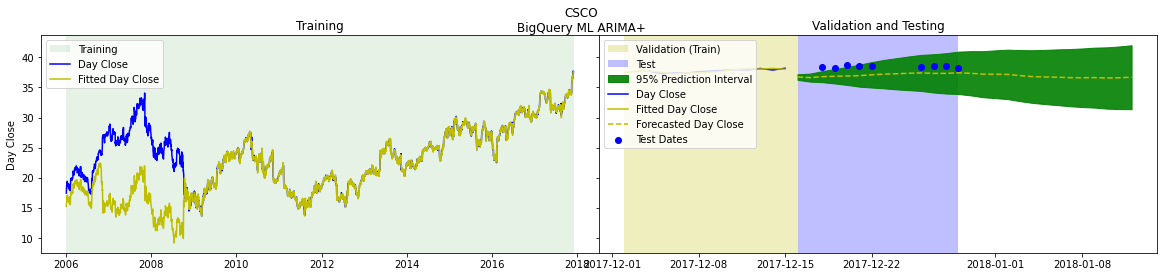

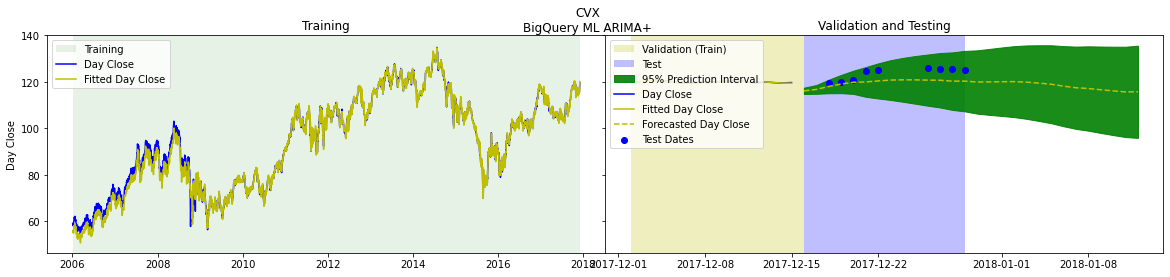

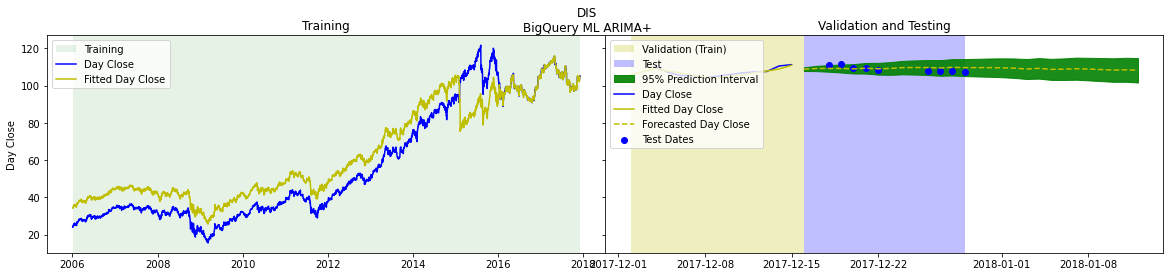

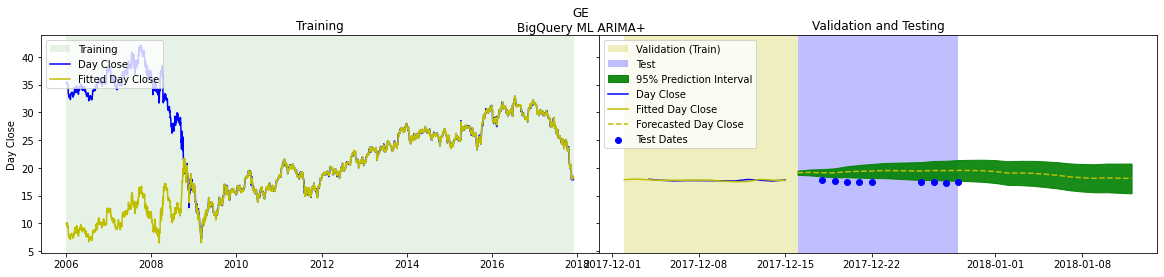

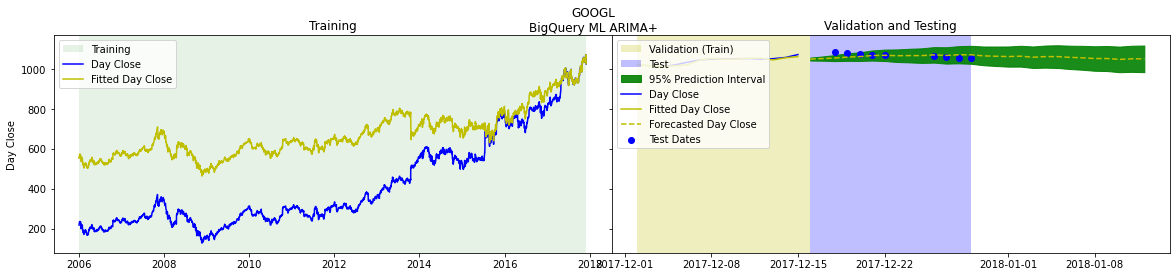

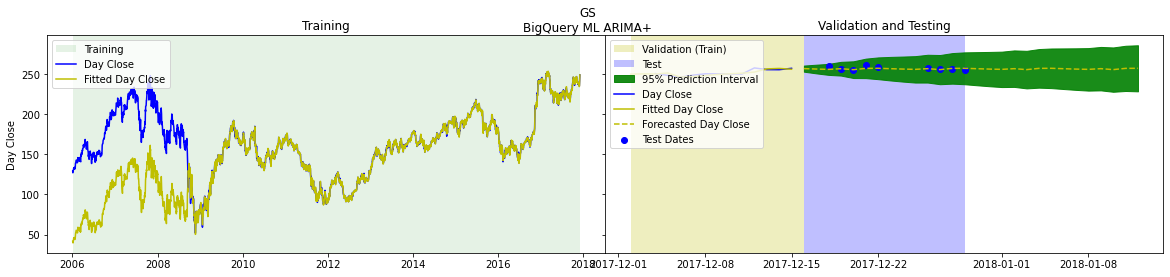

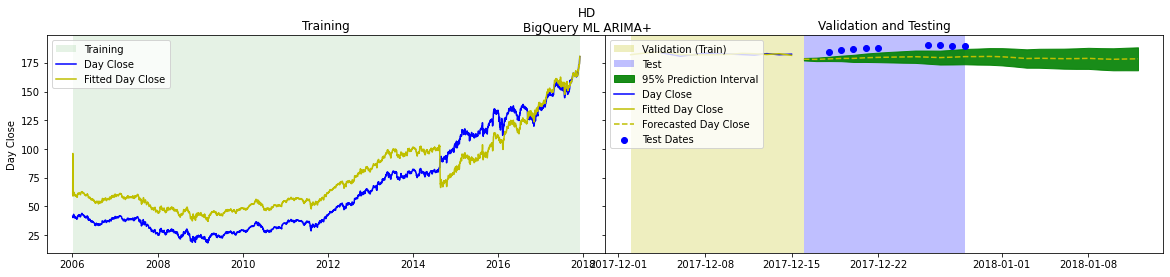

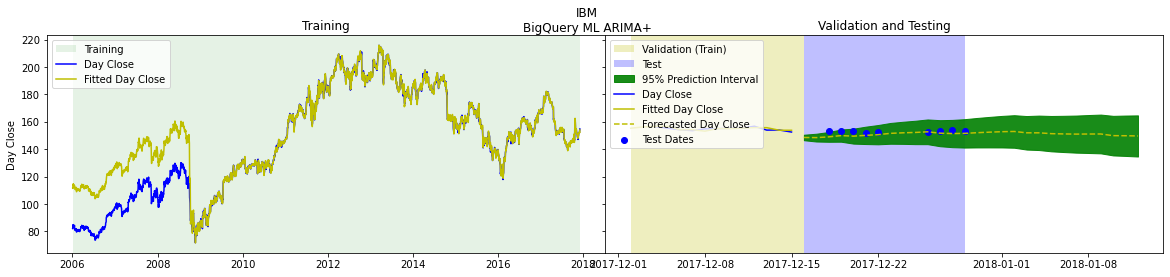

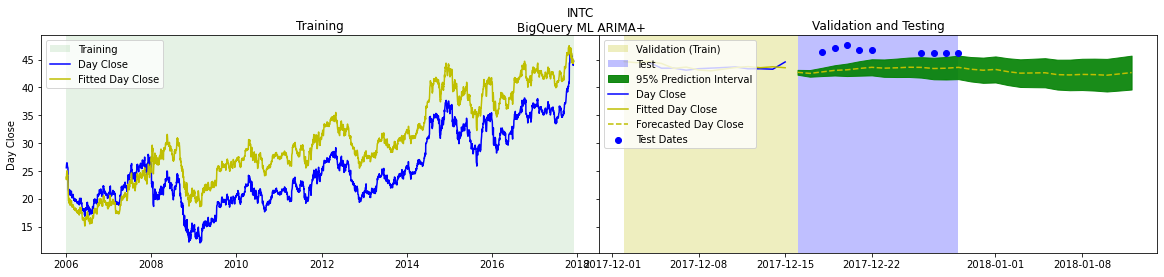

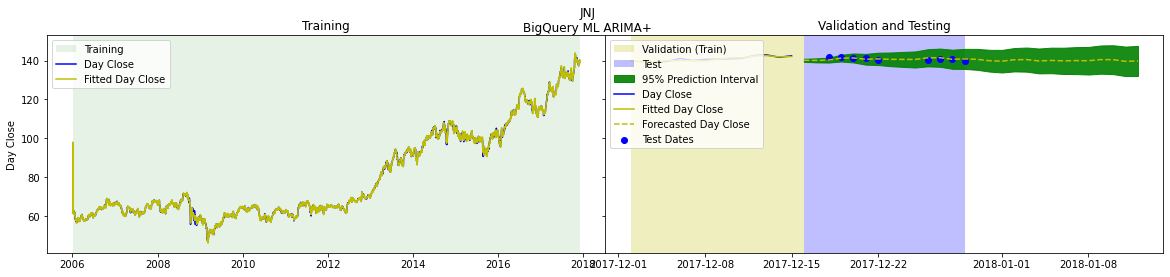

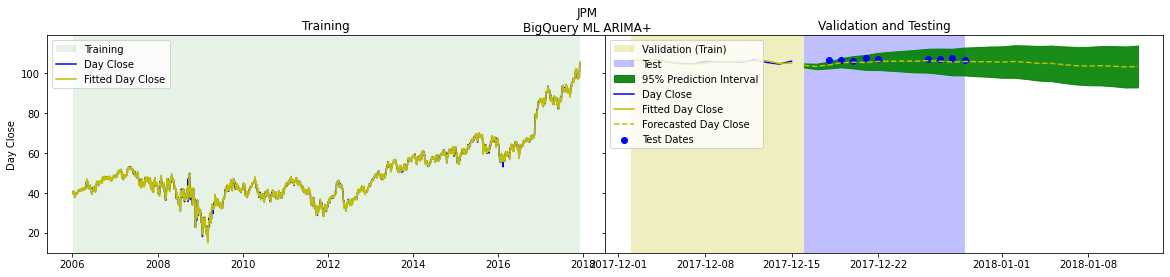

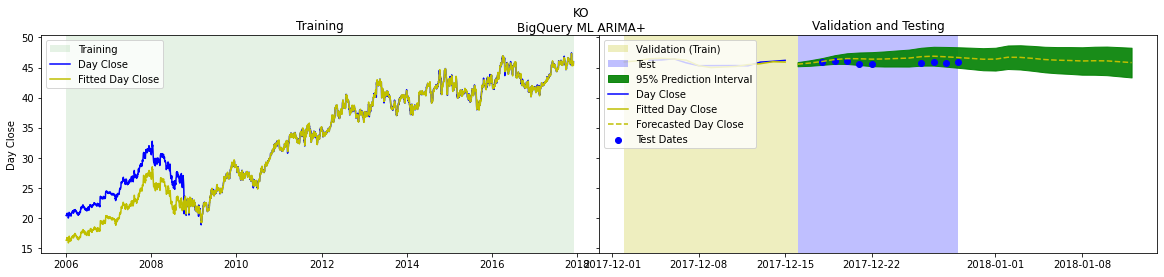

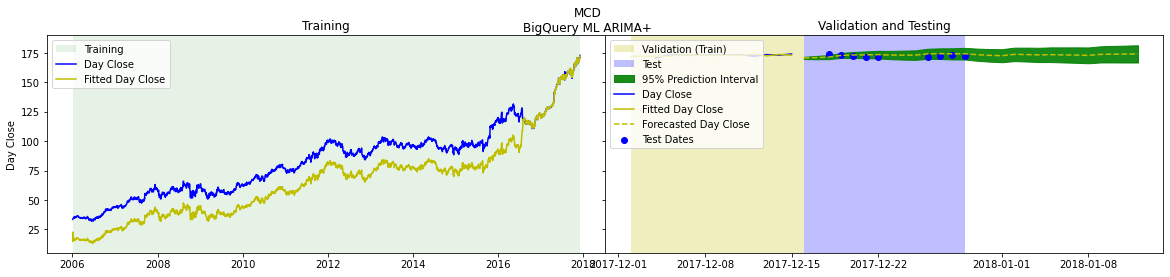

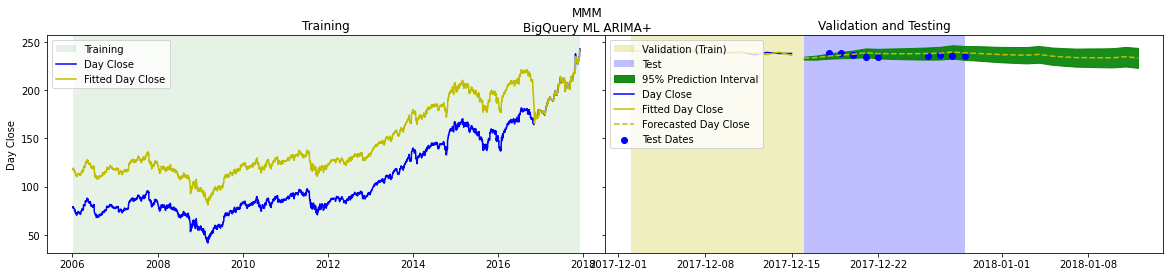

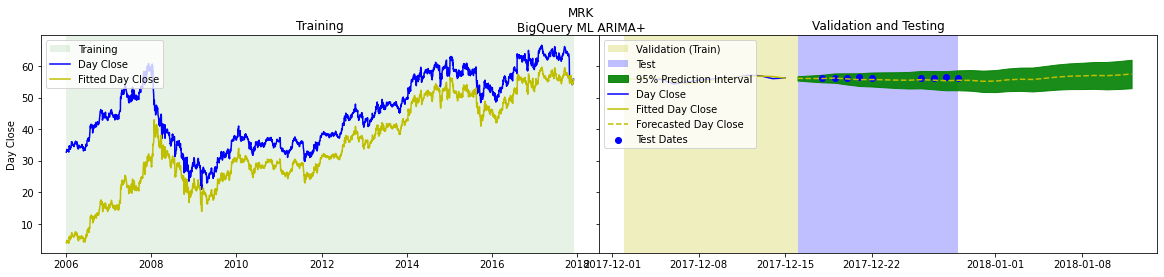

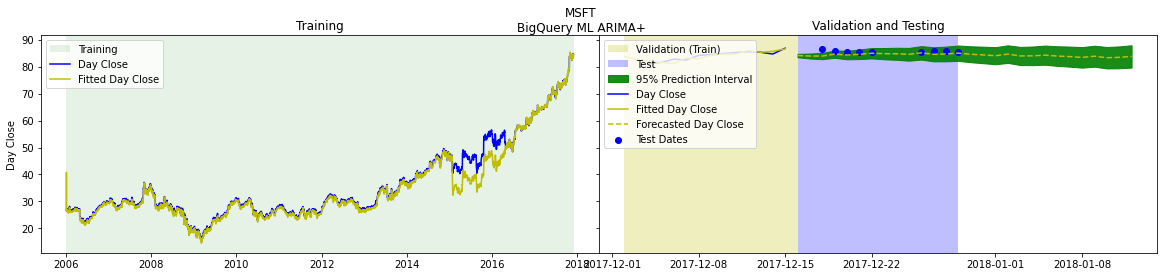

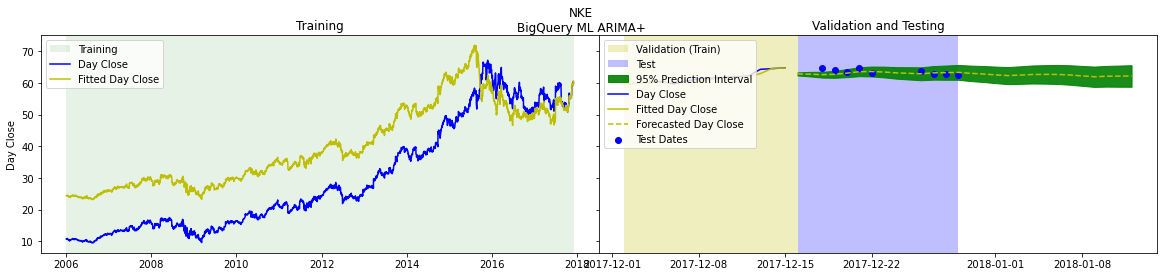

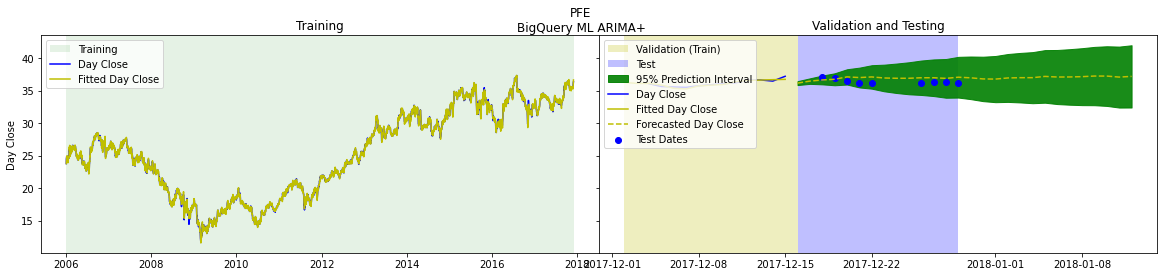

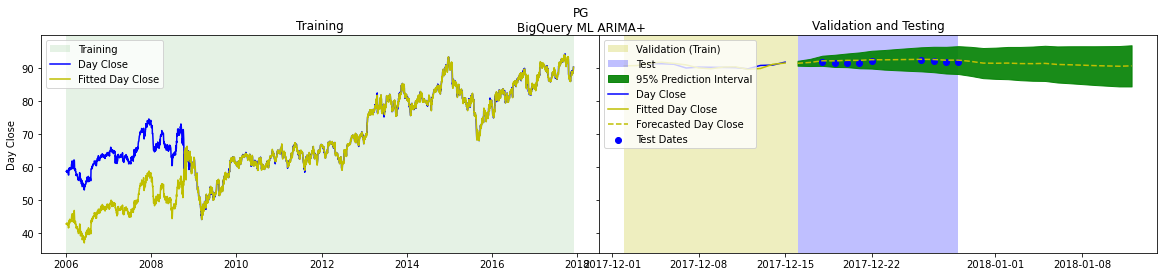

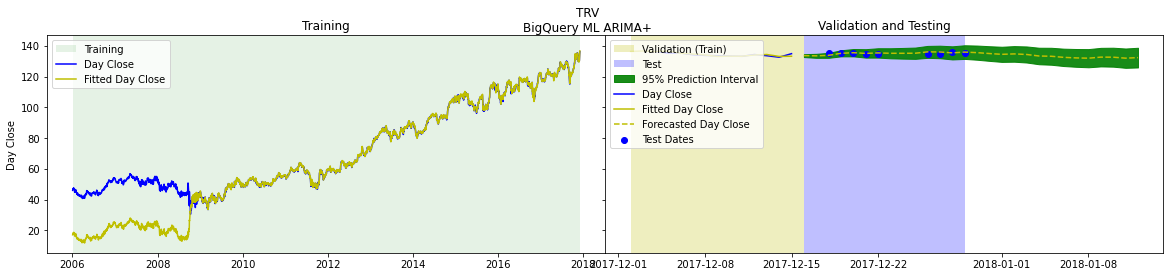

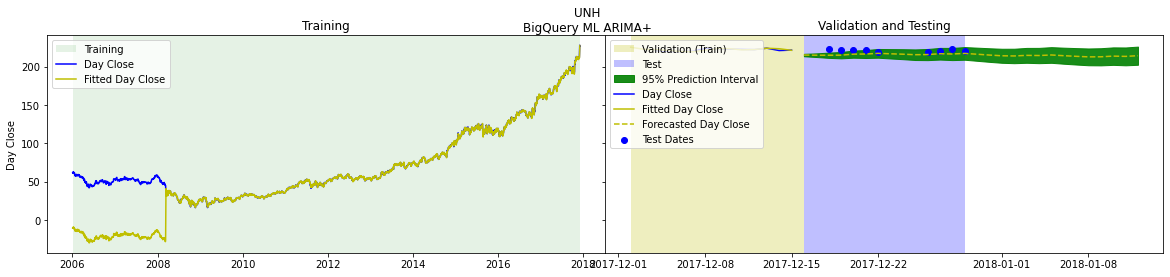

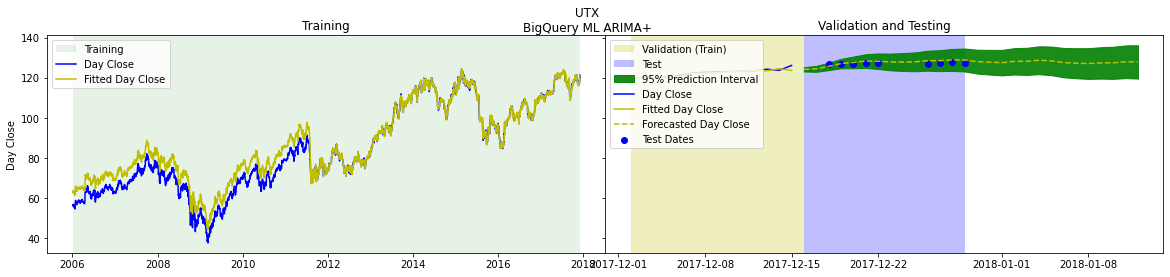

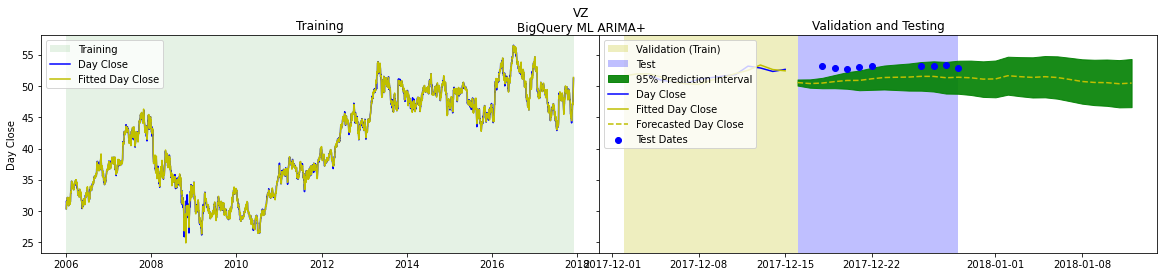

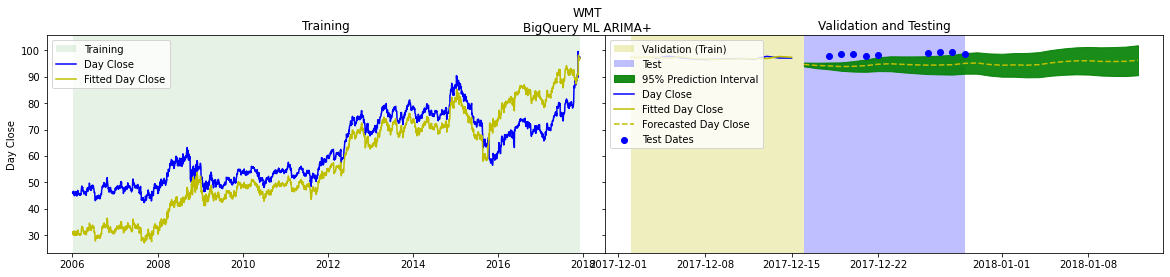

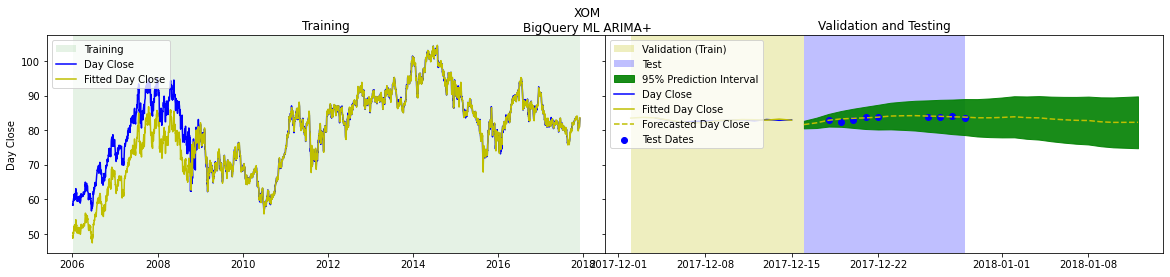

In [68]:
stations = rawSeries['name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_traindf = explain[(explain['name'] == st) & (explain['date'] < keyDates['val_start'][0])]
    fit_valdf = explain[(explain['name'] == st) & (explain['date'] >= keyDates['val_start'][0]) & (explain['date'] < keyDates['test_start'][0])]
    fit_testdf = explain[(explain['name'] == st) & (explain['date'] >= keyDates['test_start'][0])]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(fit_testdf['date'], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['close'], color = 'b', label = 'Day Close')
    axes[1].plot(valdf['date'], valdf['close'], color = 'b', label = 'Day Close')
    
    axes[0].plot(fit_traindf['date'], fit_traindf['time_series_adjusted_data'], color = 'y', label = 'Fitted Day Close')
    axes[1].plot(fit_valdf['date'], fit_valdf['time_series_adjusted_data'], color = 'y', label = 'Fitted Day Close')
    axes[1].plot(fit_testdf['date'], fit_testdf['time_series_adjusted_data'], color = 'y', label = 'Forecasted Day Close', linestyle='dashed')
    
    axes[1].scatter(testdf['date'], testdf['close'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Day Close')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nBigQuery ML ARIMA+")

    # display result
    plt.show()


In [69]:
# Custom metric calculation
query = f"""
WITH
    FORECAST AS (
        SELECT
            name, 
            EXTRACT(DATE from time_series_timestamp) as date,
            time_series_adjusted_data as forecast_value,
            time_series_type
        FROM ML.EXPLAIN_FORECAST(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`, STRUCT({keyDates['forecast_horizon'][0]} AS horizon, 0.95 AS confidence_level))
        WHERE time_series_type = 'forecast'
    ),
    ACTUAL AS (
        SELECT name, date, close as actual_value
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        WHERE splits = 'TEST'
    ),
    COMBINED AS (
        SELECT *
        FROM FORECAST
        INNER JOIN ACTUAL
        USING (name, date)  
    ),
    DIFFS AS (
        SELECT name, date, 'forecast' as time_series_type, 
            actual_value, forecast_value, (actual_value - forecast_value) as diff
        FROM COMBINED
    )
SELECT Name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY name, time_series_type
ORDER BY name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

Name time_series_type      MAPE        MAE      pMAE
0    AABA         forecast  0.010182   0.713704  0.010131
1    AAPL         forecast  0.015364   2.650250  0.015321
2    AMZN         forecast  0.015797  18.690371  0.015849
3     AXP         forecast  0.006578   0.653338  0.006597
4      BA         forecast  0.019617   5.812081  0.019638
5     CAT         forecast  0.077260  11.997104  0.077481
6    CSCO         forecast  0.035711   1.375521  0.035725
7     CVX         forecast  0.029363   3.664115  0.029641
8     DIS         forecast  0.013633   1.487365  0.013634
9      GE         forecast  0.107955   1.886193  0.107858
10  GOOGL         forecast  0.011588  12.409122  0.011617
11     GS         forecast  0.006342   1.640605  0.006374
12     HD         forecast  0.046346   8.735833  0.046410
13    IBM         forecast  0.014917   2.284129  0.014930
14   INTC         forecast  0.068937   3.214052  0.069055
15    JNJ         forecast  0.005421   0.762740  0.005419
16    JPM         forecast  0.013607   1.459348  0.013627
17     KO         forecast  0.014848   0.679937  0.014829
18    MCD         forecast  0.010277   1.771540  0.010272
19    MMM         forecast  0.011536   2.722244  0.011524
20    MRK         forecast  0.010638   0.600235  0.010654
21   MSFT         forecast  0.011916   1.022676  0.011936
22    NKE         forecast  0.013580   0.870153  0.013672
23    PFE         forecast  0.017827   0.648185  0.017783
24     PG         forecast  0.006082   0.558673  0.006077
25    TRV         forecast  0.005565   0.750790  0.005558
26    UNH         forecast  0.021762   4.824727  0.021798
27    UTX         forecast  0.007687   0.978542  0.007689
28     VZ         forecast  0.037454   1.989106  0.037459
29    WMT         forecast  0.043531   4.298700  0.043554
30    XOM         forecast  0.003353   0.278714  0.003337

### Anomaly Detection

In [70]:
query = f"""
SELECT * EXCEPT(date), CAST(DATE(date) AS date) AS date
FROM ML.DETECT_ANOMALIES(MODEL `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_{DATANAME}_arimaplus`, STRUCT(0.99 as anomaly_prob_threshold))
WHERE anomaly_probability >= 0.99
"""
anomalies = bigquery.query(query = query).to_dataframe()
anomalies

name  close  is_anomaly  lower_bound  upper_bound  anomaly_probability  \
0     AABA  43.21        True    41.211967    43.198270             0.990801   
1     AABA  40.11        True    37.896394    39.882698             0.998114   
2     AABA  35.00        True    35.054452    37.040756             0.993233   
3     AABA  31.30        True    29.183186    31.169490             0.996121   
4     AABA  33.54        True    31.336754    33.323057             0.997962   
...    ...    ...         ...          ...          ...                  ...   
3264   XOM  76.57        True    73.302405    76.214005             0.998322   
3265   XOM  76.70        True    73.528686    76.440285             0.997257   
3266   XOM  78.48        True    74.497570    77.409170             0.999955   
3267   XOM  86.90        True    83.745338    86.656938             0.997015   
3268   XOM  90.58        True    90.862129    93.773729             0.997552   

            date  
0     2006-01-06  
1     2006-01-17  
2     2006-02-01  
3     2006-04-18  
4     2006-04-19  
...          ...  
3264  2016-01-22  
3265  2016-01-26  
3266  2016-02-03  
3267  2016-09-28  
3268  2016-12-14  

[3269 rows x 7 columns]

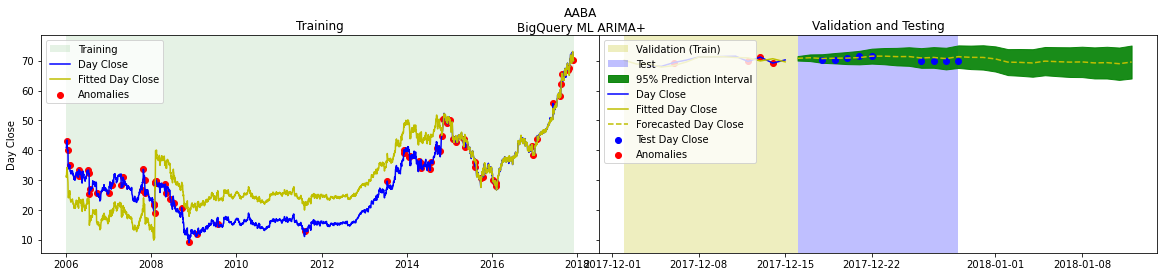

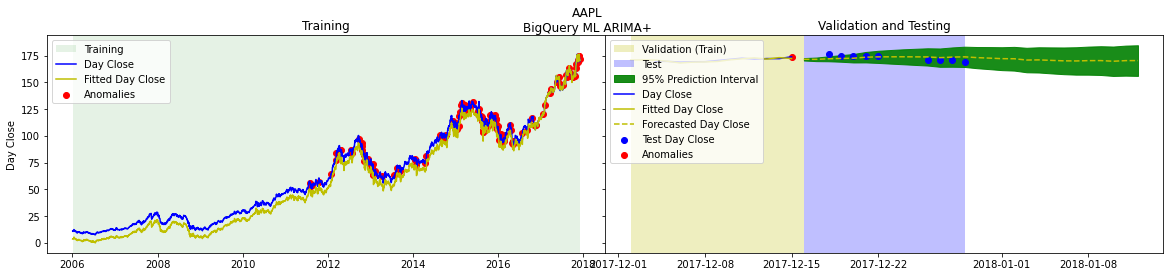

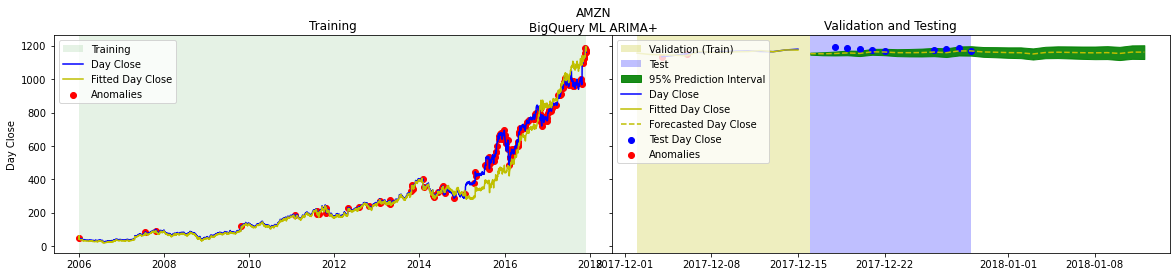

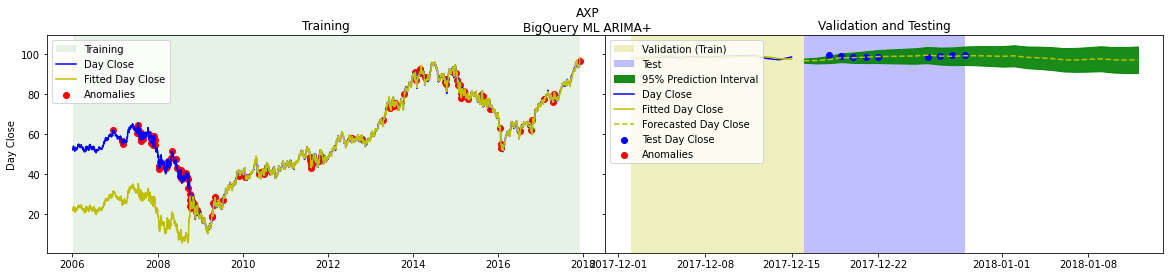

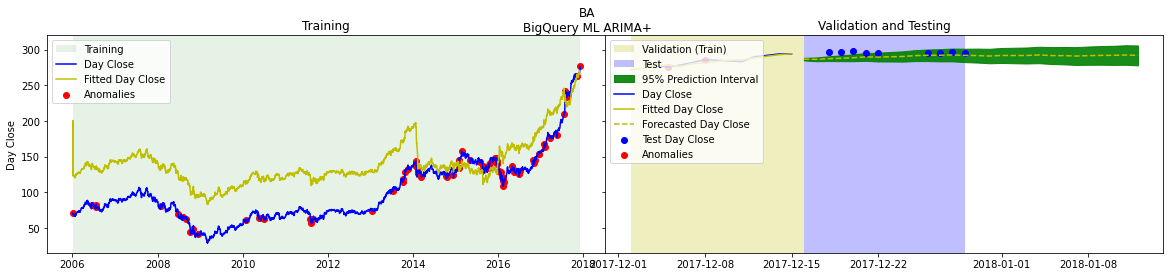

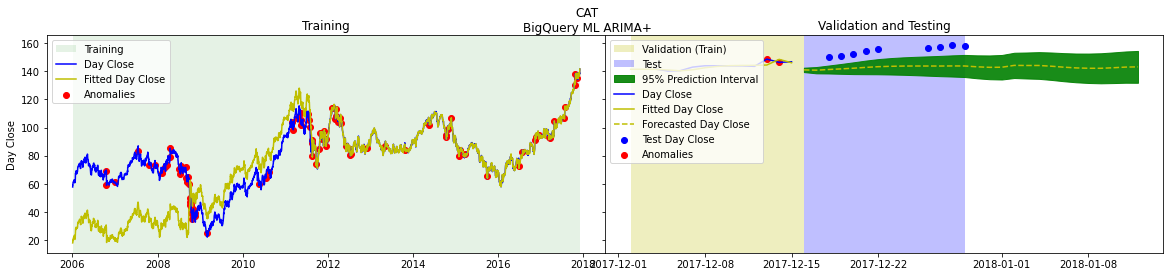

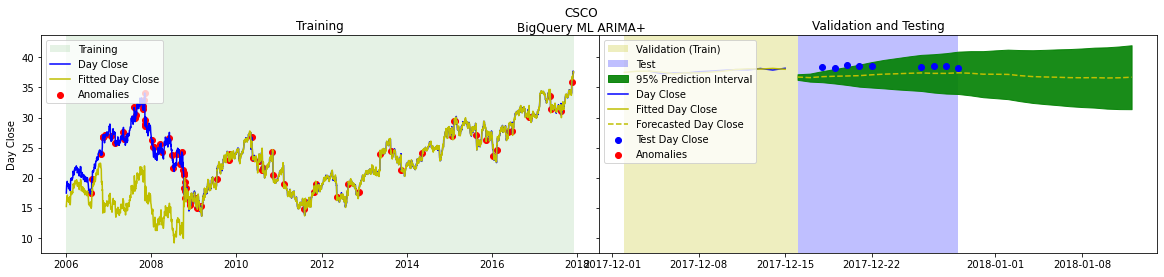

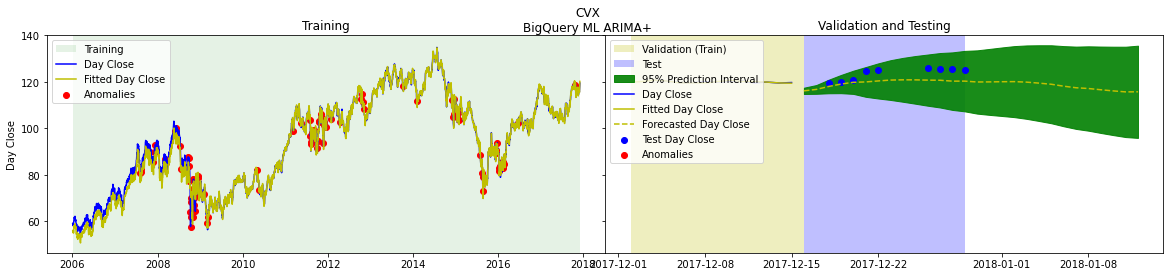

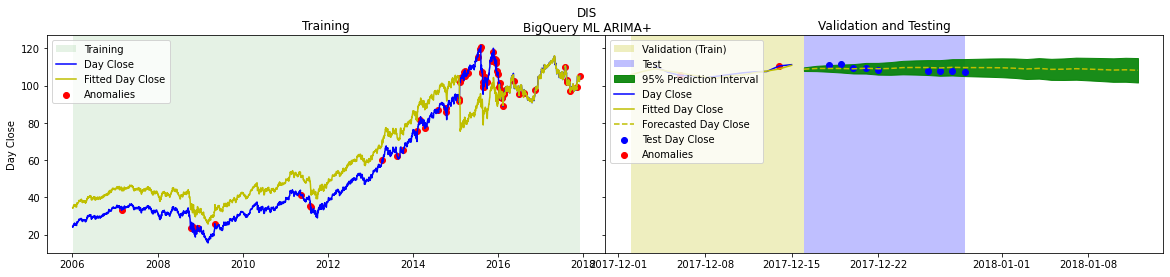

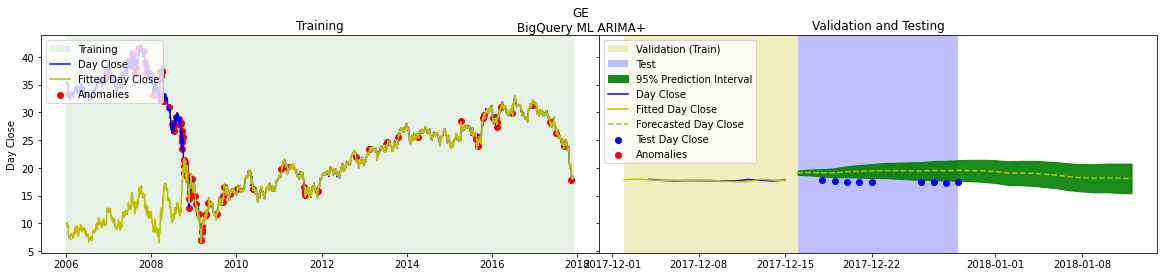

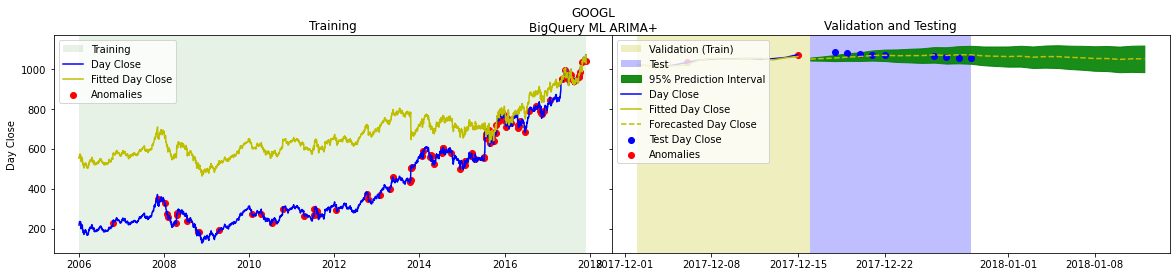

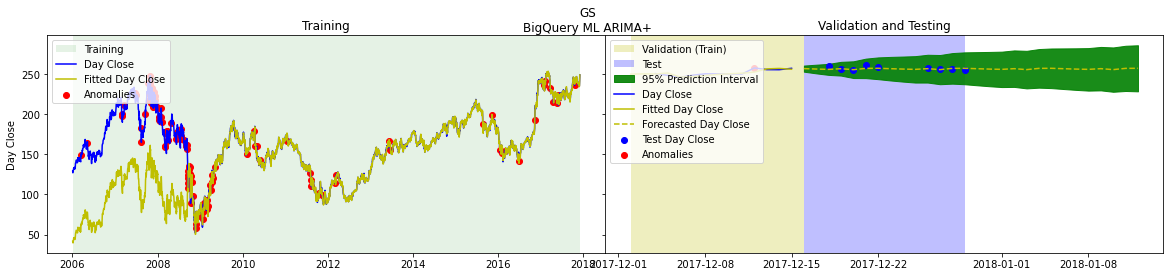

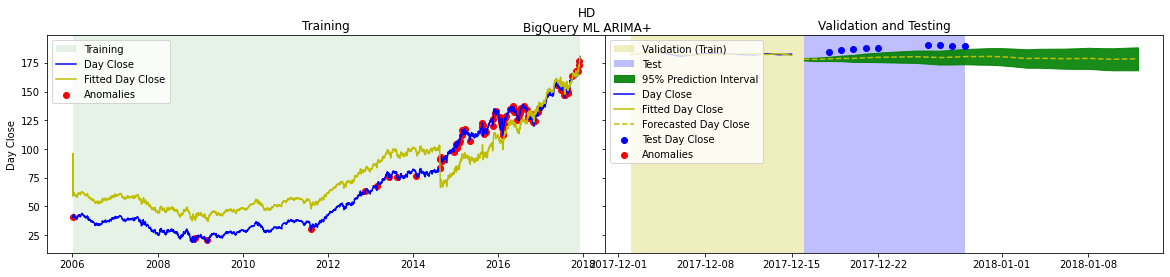

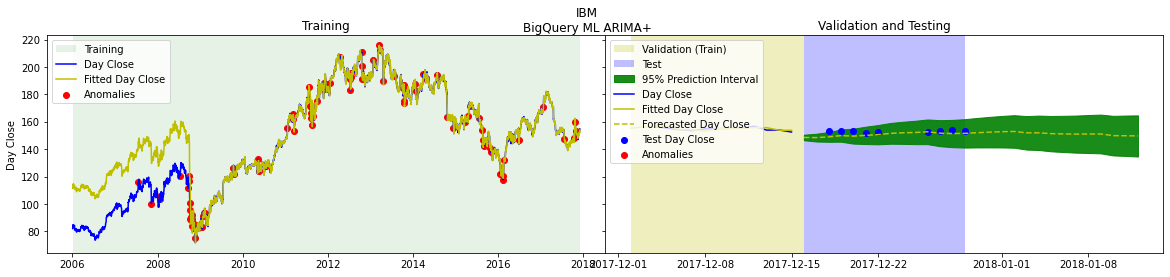

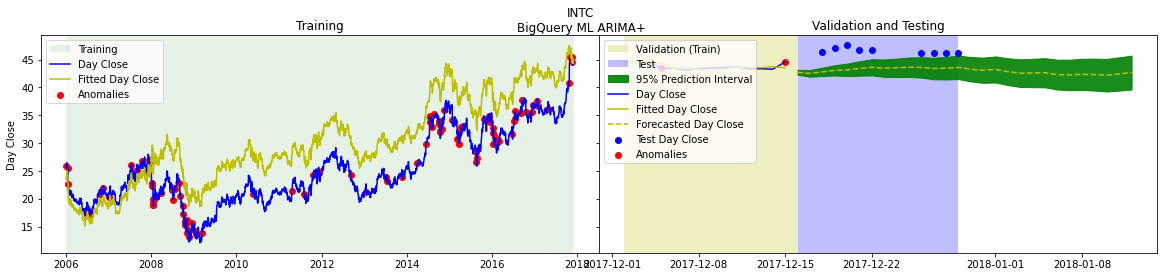

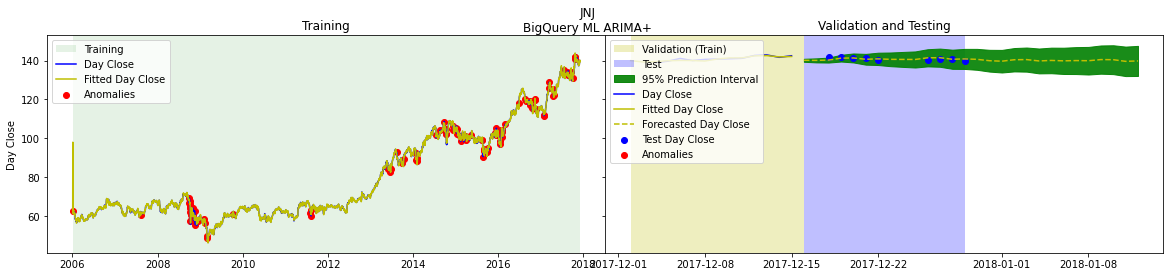

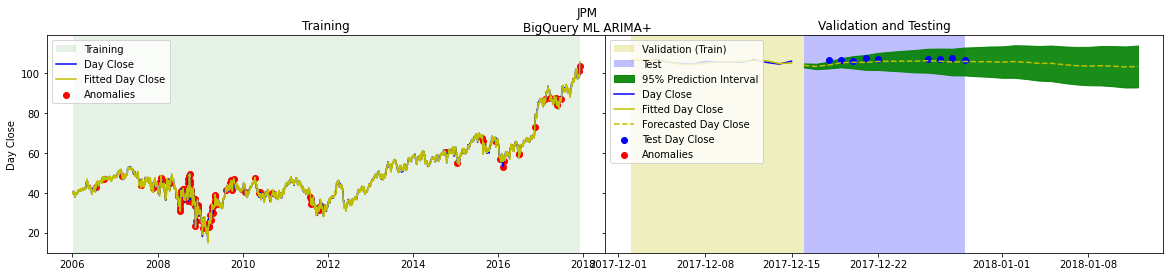

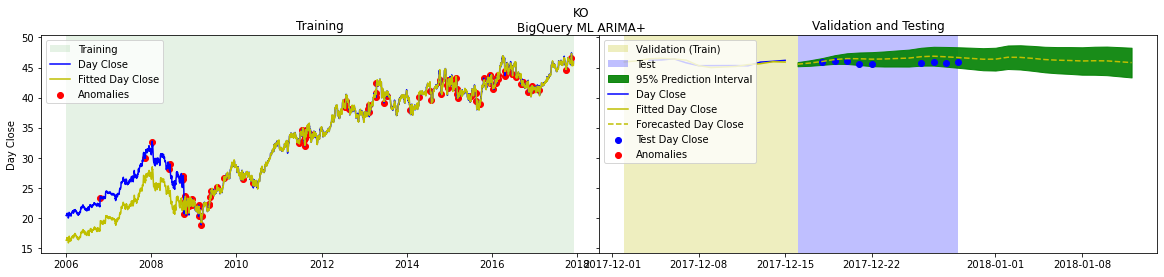

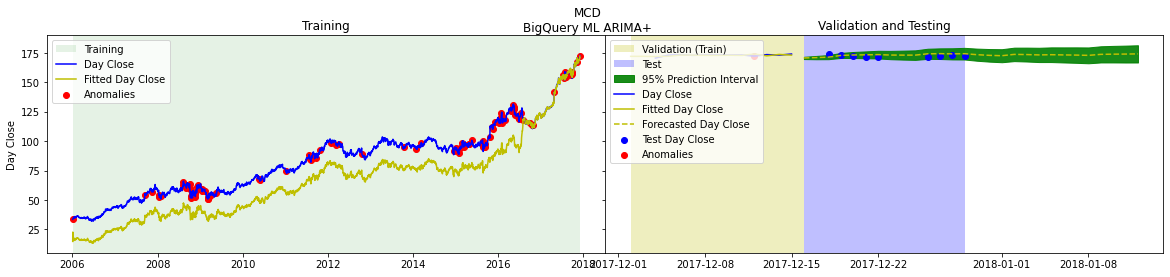

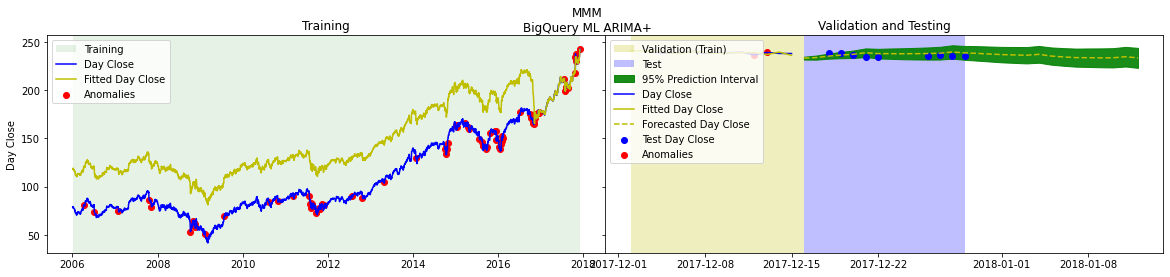

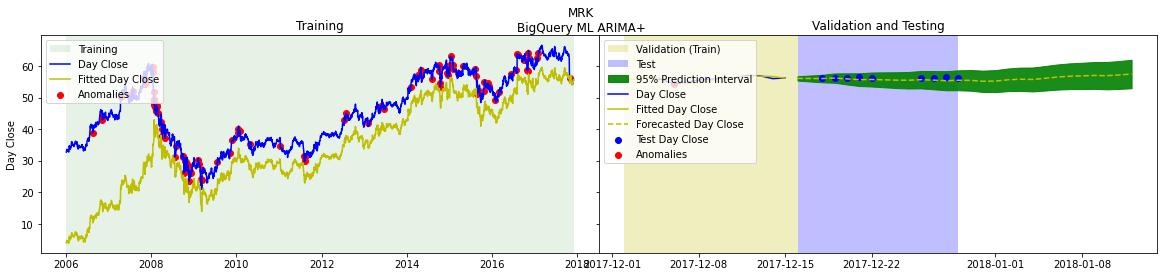

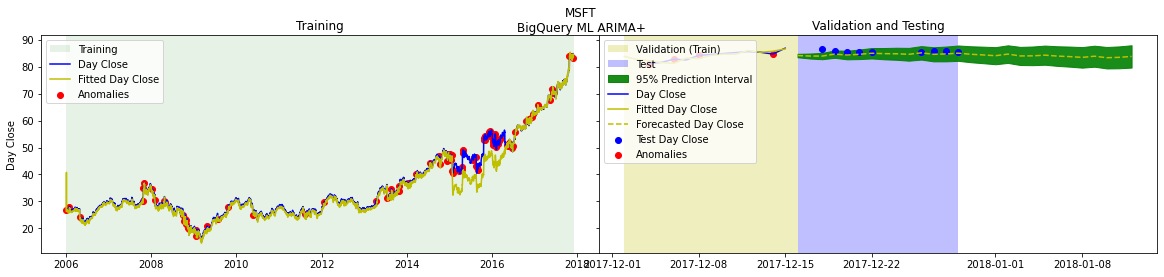

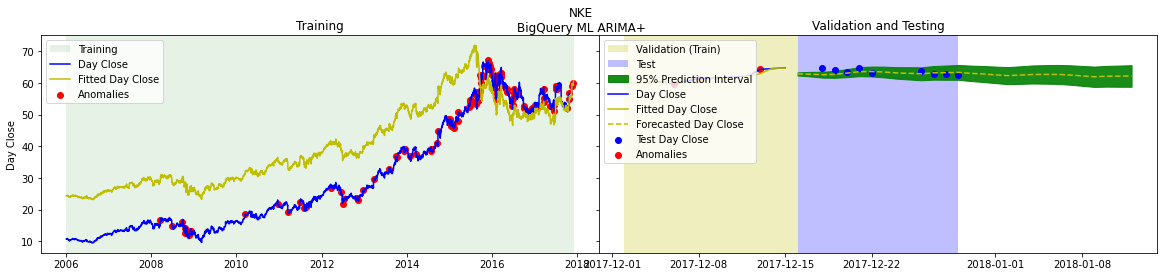

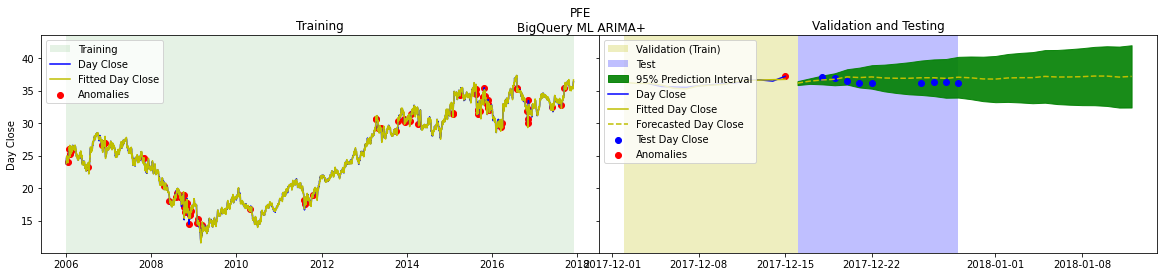

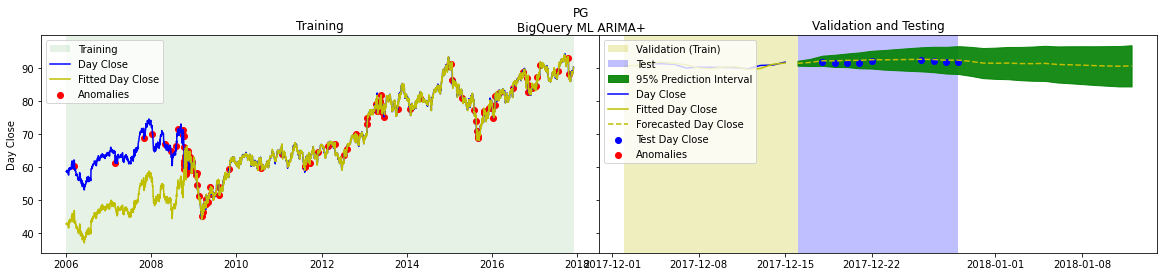

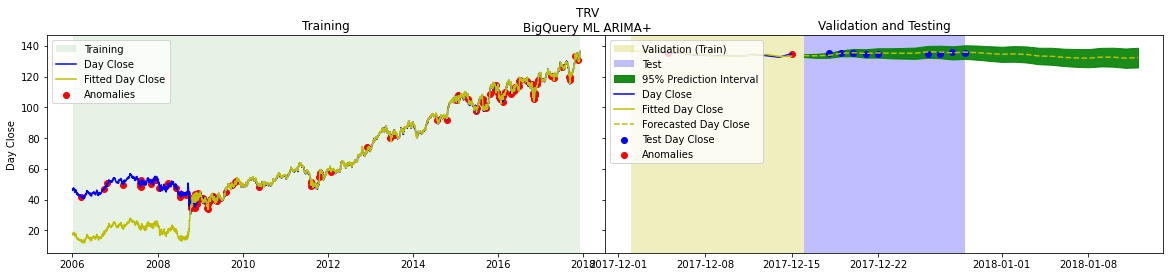

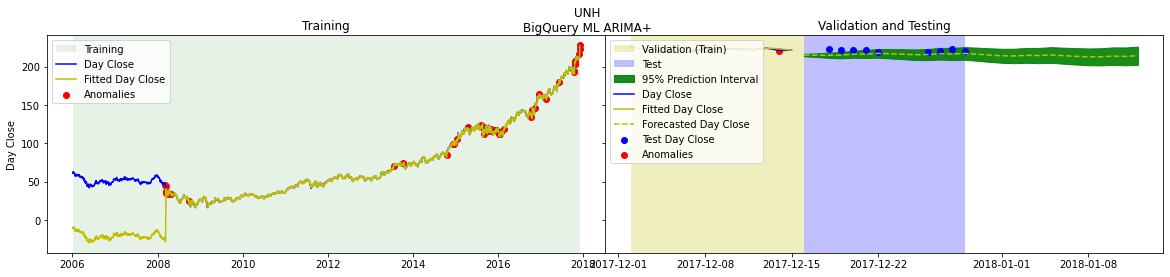

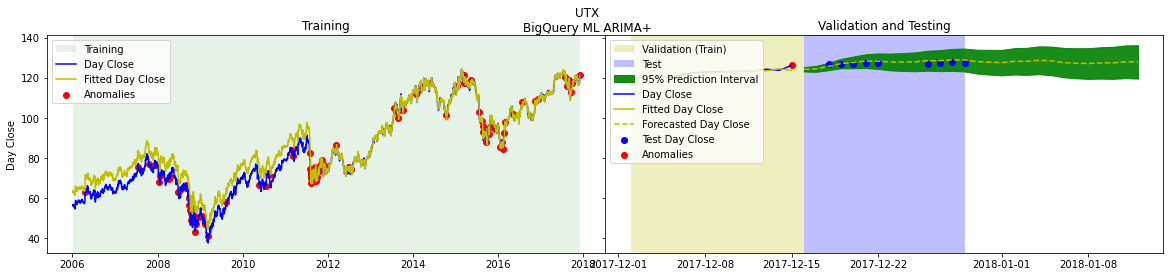

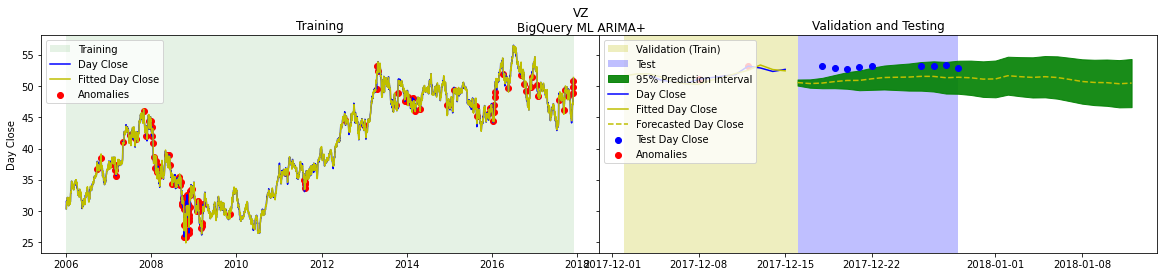

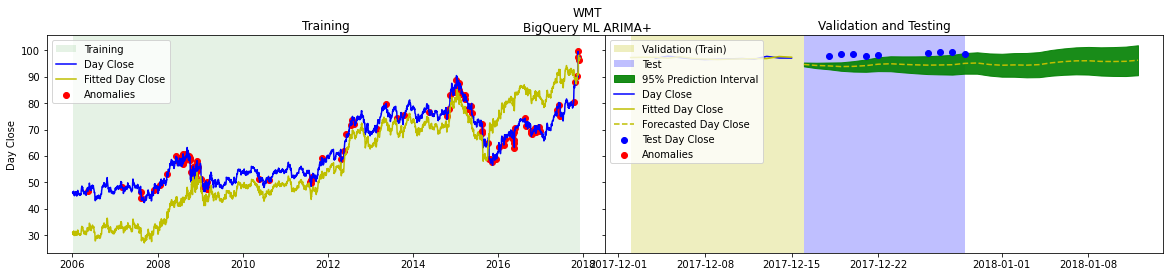

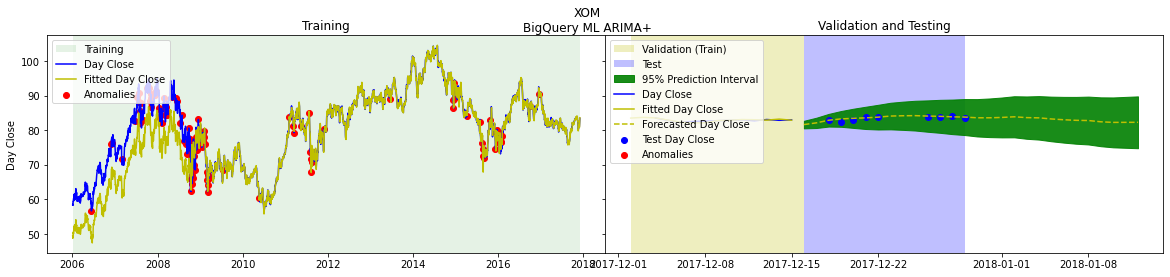

In [71]:
stations = rawSeries['name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_traindf = explain[(explain['name'] == st) & (explain['date'] < keyDates['val_start'][0])]
    fit_valdf = explain[(explain['name'] == st) & (explain['date'] >= keyDates['val_start'][0]) & (explain['date'] < keyDates['test_start'][0])]
    fit_testdf = explain[(explain['name'] == st) & (explain['date'] >= keyDates['test_start'][0])]
    anomalies_traindf = anomalies[(anomalies['name'] == st) & (anomalies['date'] < keyDates['val_start'][0])]
    anomalies_valdf = anomalies[(anomalies['name'] == st) & (anomalies['date'] >= keyDates['val_start'][0])]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(fit_testdf['date'], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['close'], color = 'b', label = 'Day Close')
    axes[1].plot(valdf['date'], valdf['close'], color = 'b', label = 'Day Close')
    
    axes[0].plot(fit_traindf['date'], fit_traindf['time_series_adjusted_data'], color = 'y', label = 'Fitted Day Close')
    axes[1].plot(fit_valdf['date'], fit_valdf['time_series_adjusted_data'], color = 'y', label = 'Fitted Day Close')
    axes[1].plot(fit_testdf['date'], fit_testdf['time_series_adjusted_data'], color = 'y', label = 'Forecasted Day Close', linestyle='dashed')
    
    axes[1].scatter(testdf['date'], testdf['close'], color = 'b', label = 'Test Day Close')
    
    axes[0].scatter(anomalies_traindf['date'], anomalies_traindf['close'], color = 'r', label = 'Anomalies')
    axes[1].scatter(anomalies_valdf['date'], anomalies_valdf['close'], color = 'r', label = 'Anomalies')
    
    # labels
    axes[0].set_ylabel('Day Close')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nBigQuery ML ARIMA+")

    # display result
    plt.show()

## Vertex Forecast